# Evaluate inversion results
This jupyter notebook evaluates and plots the results of the joint inversion for the SWARM project. In particular, this notebook plots the inversion stats, inverted field maps, depth slices, crosssections, density-suscptibility relationship and cluster locations for the Supplementary material.

### jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 04/10/2024

In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from cmcrameri import cm
from tqdm.notebook import tqdm, trange
import time
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.interpolate import griddata
import glob
from PIL import Image

In [2]:
inv_run = "SWARM_VI_airy_reprojected_coupling_20k_run1/"

In [3]:
Mag_data_pd = pd.read_csv(
    "DATA/Mag_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "Alti", "Mag"],
)

Grav_data_pd = pd.read_csv(
    "DATA/Grav_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "Grav", "Alti"],
)

Boundaries_SWARM = pd.read_csv(
    "DATA/Topo_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "bedrock"],
)

In [4]:
x_study_area = [-1689000, -1656500, -1656500, -1689000, -1689000]
y_study_area = [1723500, 1723500, 1802000, 1802000, 1723500]

In [5]:
export_fig_path = inv_run + "Output/Figure/"

# Create path if it does not exists
if not os.path.exists(export_fig_path):
    os.makedirs(export_fig_path)

unit_dens = "kg/m$^3$"
unit_sus = "SI"

In [6]:
###### Grav data ######
nc = nc4.Dataset(inv_run + "VI_inversion/gravdata.nc")  # grav data set
X_input_grav = nc.variables["MeasPosX"][:]  # x coordinates
Y_input_grav = nc.variables["MeasPosY"][:]  # y coordinates
val_input_grav = (
    nc.variables["Scalar_gravity"][:] * 1e5
)  # gravity data converted from SI units to mGal
unit_grav = "mGal"

##### Mag data ######
nc1 = nc4.Dataset(inv_run + "VI_inversion/magdata.nc")  # mag data set
X_input_mag = nc1.variables["MeasPosX"][:]  # x coordinates
Y_input_mag = nc1.variables["MeasPosY"][:]  # y coordinates
val_input_mag = nc1.variables["T"][:]  # magnetic data
unit_mag = "nT"

##### Inverted Results ######
#### Grav ####
G = nc4.Dataset(inv_run + "VI_inversion/result.inv_sgd.nc")  # syn grav data set
X_syn_grav = G.variables["MeasPosX"][:]  # x coordinates
Y_syn_grav = G.variables["MeasPosY"][:]  # y coordinates
val_syn_grav = G.variables["Scalar_gravity"][:] * 1e5  # syn gravity data

diff_grav = val_input_grav - val_syn_grav  # difference observed and syn gravity data
diff_grav_pd = pd.DataFrame(diff_grav, columns=["diff_grav"])
mxn_d = max(abs(max(diff_grav)), abs(min(diff_grav)))

#### Mag ####
G1 = nc4.Dataset(inv_run + "VI_inversion/result.inv_mag.nc")  # syn mag data set
X_syn_mag = G1.variables["MeasPosX"][:]  # x coordinates
Y_syn_mag = G1.variables["MeasPosY"][:]  # y coordinates
val_syn_mag = G1.variables["T"][:]  # syn magnetic data


diff_mag = val_input_mag - val_syn_mag  # difference observed and syn magnetic data
diff_mag_pd = pd.DataFrame(diff_mag, columns=["diff_mag"])
mxn_mag = max(abs(max(diff_mag)), abs(min(diff_mag)))


nc.close()
nc1.close()
G.close()
G1.close()

max grav error : 12.3 mGal
min grav error : -12.7 mGal
mean grav error : 0.1 mGal
std grav error : 2.5 mGal 

max mag error : 38.3 nT
min mag error : -38.2 nT
mean mag error : -0.2 nT
std mag error : 3.5 nT 



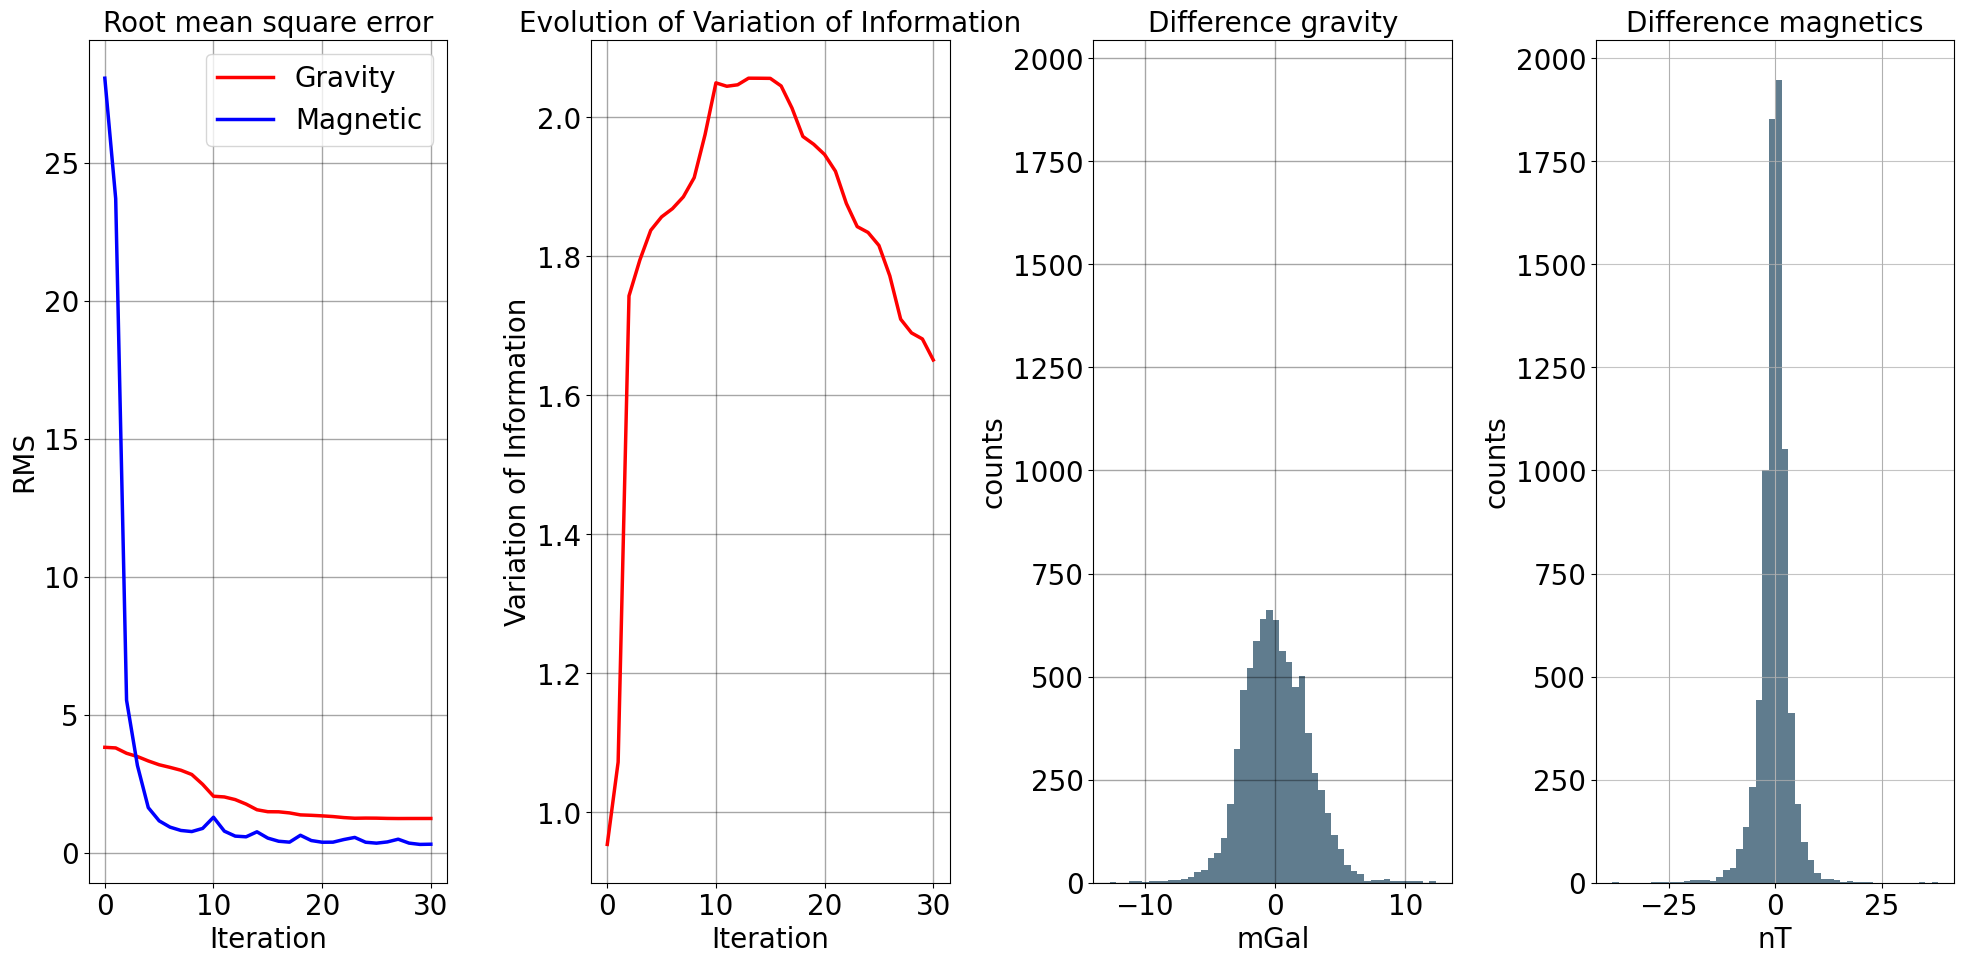

In [7]:
# load missift and rms data


run1_misfit = np.genfromtxt(inv_run + "VI_inversion/misfit.out")
run1_rms = np.genfromtxt(inv_run + "VI_inversion/rms.out")

rms = run1_rms
misfit = run1_misfit


figure1, axs = plt.subplots(1, 4, figsize=(20, 10), facecolor="white")

axs[0].plot(rms[:, 1], "-r", linewidth=2.5, label="Gravity")
axs[0].plot(rms[:, 2], "-b", linewidth=2.5, label="Magnetic")
axs[0].legend(loc="upper right", prop={"size": 20})
axs[0].set_title("Root mean square error", fontsize=20)
axs[0].set_xlabel("RMS", fontsize=20)
axs[0].grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
axs[0].set_xlabel("Iteration", fontsize=20)
axs[0].set_ylabel("RMS", fontsize=20)
axs[0].tick_params(axis="x", labelsize=20)
axs[0].tick_params(axis="y", labelsize=20)

axs[1].plot(misfit[:, 4], "-r", linewidth=2.5)
axs[1].set_title("Evolution of Variation of Information", fontsize=20)
axs[1].set_xlabel("Iteration", fontsize=20)
axs[1].set_ylabel("Variation of Information", fontsize=20)
# axs[2].sharey(axs[1])
axs[1].grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
axs[1].tick_params(axis="x", labelsize=20)
axs[1].tick_params(axis="y", labelsize=20)


diff_grav_pd.diff_grav.plot.hist(grid=True, bins=50, ax=axs[2], color="#607c8e")
axs[2].set_title("Difference gravity", fontsize=20)
axs[2].set_xlabel("mGal", fontsize=20)
axs[2].set_ylabel("counts", fontsize=20)
axs[2].grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
axs[2].tick_params(axis="x", labelsize=20)
axs[2].tick_params(axis="y", labelsize=20)


diff_mag_pd.diff_mag.plot.hist(grid=True, bins=50, ax=axs[3], color="#607c8e")
axs[3].set_title("Difference magnetics", fontsize=20)
axs[3].set_xlabel("nT", fontsize=20)
axs[3].set_ylabel("counts", fontsize=20)

axs[3].grid(axis="y", alpha=0.75)
axs[3].tick_params(axis="x", labelsize=20)
axs[3].tick_params(axis="y", labelsize=20)

axs[2].sharey(axs[3])

figure1.tight_layout(pad=2)

plt.savefig(
    export_fig_path + "inversion_stats.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)


print("max grav error :", "{0:.1f}".format(np.max(diff_grav)), "mGal")
print("min grav error :", "{0:.1f}".format(np.min(diff_grav)), "mGal"),
print("mean grav error :", "{0:.1f}".format(np.mean(diff_grav)), "mGal")
print("std grav error :", "{0:.1f}".format(np.std(diff_grav)), "mGal \n")

print("max mag error :", "{0:.1f}".format(np.max(diff_mag)), "nT")
print("min mag error :", "{0:.1f}".format(np.min(diff_mag)), "nT"),
print("mean mag error :", "{0:.1f}".format(np.mean(diff_mag)), "nT")
print("std mag error :", "{0:.1f}".format(np.std(diff_mag)), "nT \n")

In [8]:
# read in magnetic inversion model
mag_fh = Dataset(inv_run + "VI_inversion/result.mag.inv.nc")
X_sus = mag_fh.variables["Northing"][:]
Y_sus = mag_fh.variables["Easting"][:]
Depth_sus = mag_fh.variables["Depth"][:]
X_sus_Origin = mag_fh.variables["Northing_Origin"][:]
Y_sus_Origin = mag_fh.variables["Easting_Origin"][:]
Depth_sus_Origin = mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:, :, :]
mag_fh.close()

# and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset(inv_run + "VI_inversion/result.grav.inv.nc")
inv_dens = grav_fh.variables["Density"][:, :, :]
grav_fh.close()

In [9]:
xq, yq = np.meshgrid(X_sus, Y_sus)
Depth_inversion_km = np.round((Depth_sus / 1000), 1)

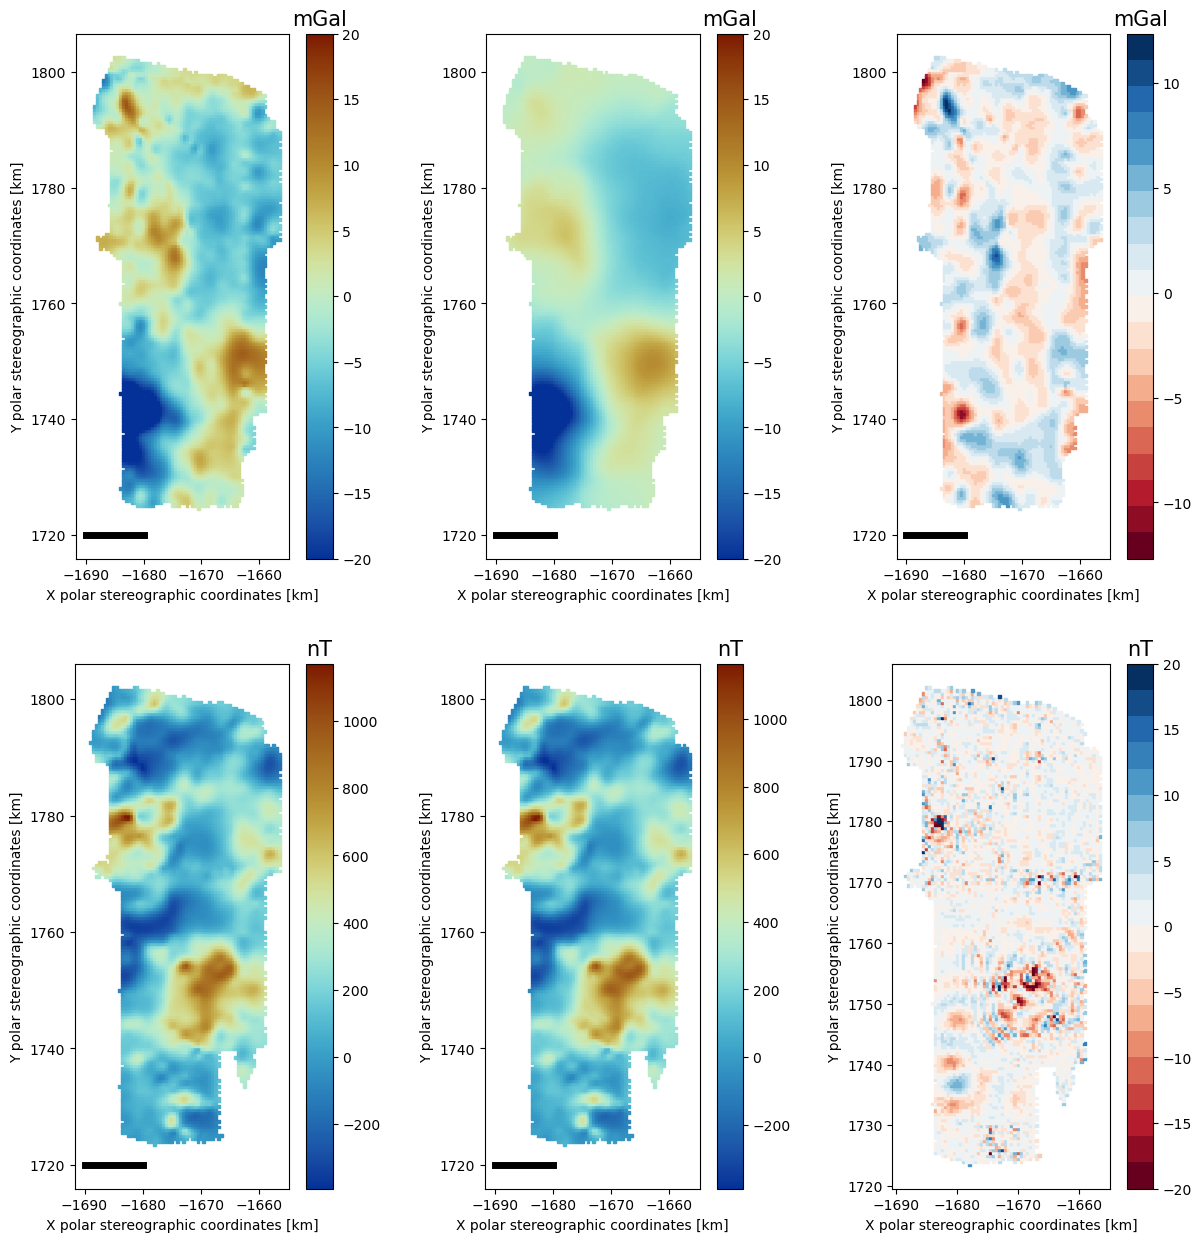

In [10]:
m = 15  # fontsize
cmap = cm.roma_r
cmap_rev = cm.roma_r
cmap_grav_diff = plt.get_cmap("RdBu", 20)


figure1 = plt.figure(figsize=(15, 15), facecolor="white")

# plot observed gravity field
ax1 = plt.subplot(2, 3, 1)
im = plt.scatter(
    X_input_grav / 1000,
    Y_input_grav / 1000,
    c=val_input_grav,
    marker="s",
    s=4,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
axes = plt.gca()
axes = plt.gca()
cb1 = plt.colorbar(im, orientation="vertical", shrink=1, pad=0.05)
cb1.ax.set_title("mGal", fontsize=15)
ax1.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax1.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar

# plot inverted gravity field
ax2 = plt.subplot(2, 3, 2)
im2 = plt.scatter(
    X_syn_grav / 1000,
    Y_syn_grav / 1000,
    c=val_syn_grav,
    marker="s",
    s=4,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=1, pad=0.05)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax2.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar


# plot difference between observed and inverted gravity field
ax3 = plt.subplot(2, 3, 3)
im3 = plt.scatter(
    X_input_grav / 1000,
    Y_input_grav / 1000,
    c=diff_grav,
    marker="s",
    s=4,
    cmap=cmap_grav_diff,
)  # , vmin=-mxn_d/10, vmax=mxn_d/10)
axes = plt.gca()
cb3 = plt.colorbar(im3, orientation="vertical", shrink=1, pad=0.05)
cb3.ax.set_title("mGal", fontsize=15)
ax3.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax3.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar


# plot observed magnetic field
ax4 = plt.subplot(2, 3, 4)
im4 = plt.scatter(
    X_input_mag / 1000, Y_input_mag / 1000, c=val_input_mag, marker="s", s=4, cmap=cmap
)
axes = plt.gca()
cb4 = plt.colorbar(im4, orientation="vertical", shrink=1, pad=0.05)
cb4.ax.set_title("nT", fontsize=15)
ax4.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax4.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar

# plot inverted magnetic field
ax5 = plt.subplot(2, 3, 5)
im5 = plt.scatter(
    X_syn_mag / 1000, Y_syn_mag / 1000, c=val_syn_mag, marker="s", s=4, cmap=cmap
)
axes = plt.gca()
cb5 = plt.colorbar(im5, orientation="vertical", shrink=1, pad=0.05)
cb5.ax.set_title("nT", fontsize=15)
ax5.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax5.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar

# plot difference between observed and inverted magnetic field
ax6 = plt.subplot(2, 3, 6)
cmap = plt.get_cmap("RdBu", 20)
im6 = plt.scatter(
    X_input_mag / 1000,
    Y_input_mag / 1000,
    c=diff_mag,
    marker="s",
    s=4,
    cmap=cmap_grav_diff,
    vmin=-20,
    vmax=20,
)
axes = plt.gca()
cb6 = plt.colorbar(im6, orientation="vertical", shrink=1, pad=0.05)
cb6.ax.set_title("nT", fontsize=15)
ax6.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)

plt.savefig(
    export_fig_path + "VI_inversion_maps.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

# plot horizontal profiles

In [11]:
xq, yq = np.meshgrid(X_sus, Y_sus)
Depth_inversion_km = np.round((Depth_sus / 1000), 1)

In [12]:
topointer = griddata(
    (Boundaries_SWARM.x_ps, Boundaries_SWARM.y_ps),
    Boundaries_SWARM.bedrock,
    (xq, yq),
    method="linear",
)
x_profil, z_profil = np.meshgrid(X_sus, Depth_sus)

In [13]:
# VI_model = np.vstack(
#     (
#         inv_sus.flatten(),
#         inv_dens.flatten(),
#         x_stack.flatten(),
#         y_stack.flatten(),
#         z_stack.flatten(),
#         VI_cov_mesh.flatten(),
#     )
# ).T

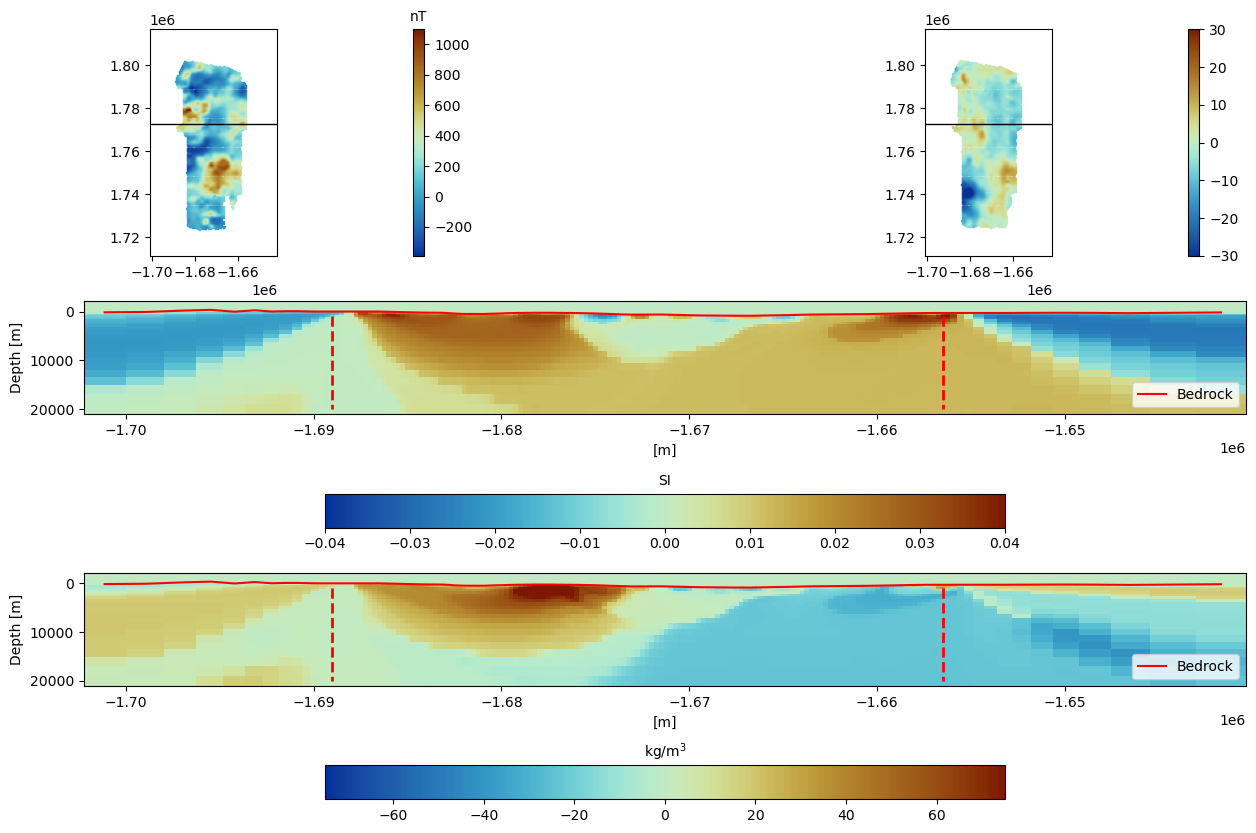

In [14]:
export_profiles = inv_run + "Output/Figure/profiles/"

# Create path if it does not exists
if not os.path.exists(export_profiles):
    os.makedirs(export_profiles)

# define fontsize
fontsize_index = 10


j = 209

sus_profil_ix = inv_sus[:, j, :]
line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
line_y = (yq[j, 0], yq[j, 0])
dens_profil_ix = inv_dens[:, j, :]

## plot profile location
figure1 = plt.figure(figsize=(15, 10), facecolor="white")
spec = figure1.add_gridspec(3, 2, hspace=0.2, wspace=1)
ax0 = figure1.add_subplot(spec[0, 0])

im1 = plt.scatter(
    X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=0.5, cmap=cmap_rev, vmax=1100
)

axes = plt.gca()
cb1 = plt.colorbar(im1, shrink=1, orientation="vertical", pad=0.35)
cb1.ax.set_title("nT", fontsize=fontsize_index)
ax0.plot(line_x, line_y, color="k", linewidth=1)
plt.gca().set_aspect(1)
ax0.set_xlim(np.min(X_sus), np.max(X_sus))
ax0.set_ylim(np.min(Y_sus), np.max(Y_sus))

# plot sus profil
ax2 = figure1.add_subplot(spec[1, :])
im2 = plt.pcolormesh(
    x_profil, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("[m]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)

ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.35)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(x_profil[0, :], topointer[j, :] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
ax2.vlines(
    x=[np.min(x_study_area), np.max(x_study_area)],
    ymin=[1000, 1000],
    ymax=[20000, 20000],
    colors="red",
    ls="--",
    lw=2,
)

ax3 = figure1.add_subplot(spec[0, 1])

im3 = plt.scatter(
    X_input_grav,
    Y_input_grav,
    c=val_input_grav,
    marker="s",
    s=0.5,
    cmap=cmap_rev,
    vmin=-30,
    vmax=30,
)
axes = plt.gca()
cb3 = plt.colorbar(im3, shrink=1, orientation="vertical", pad=0.35)
ax3.plot(line_x, line_y, color="k", linewidth=1)
plt.gca().set_aspect(1)
ax3.set_xlim(np.min(X_sus), np.max(X_sus))
ax3.set_ylim(np.min(Y_sus), np.max(Y_sus))

# plot sus profil
ax4 = figure1.add_subplot(spec[2, :])
im4 = plt.pcolormesh(
    x_profil,
    z_profil,
    dens_profil_ix,
    cmap=cmap_rev,
    vmin=-75,
    vmax=75,
)
plt.xlabel("[m]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im4, shrink=1, orientation="horizontal", pad=0.35)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(x_profil[0, :], topointer[j, :] * -1, c="red", label="Bedrock")

ax4.legend(loc="lower right", prop={"size": 10})
ax4.vlines(
    x=[np.min(x_study_area), np.max(x_study_area)],
    ymin=[1000, 1000],
    ymax=[20000, 20000],
    colors="red",
    ls="--",
    lw=2,
)
plt.savefig(
    export_profiles + "VI_horizontal_profile_overview.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

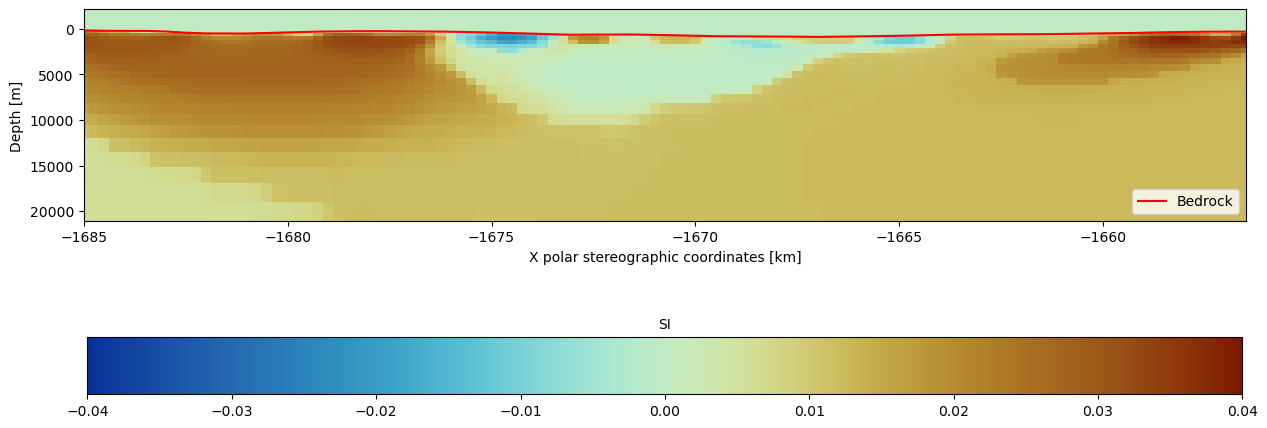

In [15]:
# define fontsize
fontsize_index = 10

j = 209

sus_profil_ix = inv_sus[:, j, :]
line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
line_y = (yq[j, 0], yq[j, 0])
dens_profil_ix = inv_dens[:, j, :]

## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = ax2.pcolormesh(
    x_profil / 1000, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([-1685000 / 1000, -1656500 / 1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(x_profil[0, :] / 1000, topointer[j, :] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
plt.savefig(
    export_profiles + "sus_horizontal_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

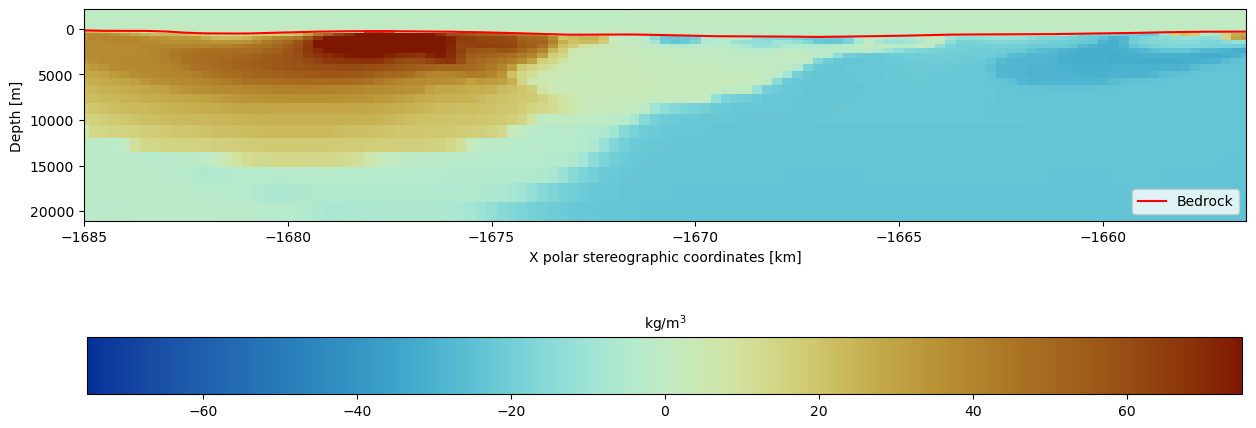

In [16]:
# define fontsize
fontsize_index = 10


j = 209

sus_profil_ix = inv_sus[:, j, :]
line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
line_y = (yq[j, 0], yq[j, 0])
dens_profil_ix = inv_dens[:, j, :]


## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)


# plot sus profil
im2 = plt.pcolormesh(
    x_profil / 1000, z_profil, dens_profil_ix, cmap=cmap_rev, vmin=-75, vmax=75
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([-1685000 / 1000, -1656500 / 1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(x_profil[0, :] / 1000, topointer[j, :] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
plt.savefig(
    export_profiles + "density_horizontal_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

# Plot obsereved and inverted data points along profiles

In [17]:
# Merge data variables into one data container to identify profile coordinates and data
Mag_obs_merged = np.vstack((X_input_mag, Y_input_mag, val_input_mag)).T
Mag_syn_merged = np.vstack((X_syn_mag, Y_syn_mag, val_syn_mag)).T
Grav_obs_merged = np.vstack((X_input_grav, Y_input_grav, val_input_grav)).T
Grav_syn_merged = np.vstack((X_syn_grav, Y_syn_grav, val_syn_grav)).T

In [18]:
# find data points for horizontal profile

obs_mag_horizontal_profile_ix = []
for i in range(len(Mag_obs_merged[:, 0])):
    if Mag_obs_merged[i, 1] == 1772500:
        obs_mag_horizontal_profile_ix.append(Mag_obs_merged[i, :])
obs_mag_horizontal_profile = np.array(obs_mag_horizontal_profile_ix)


syn_mag_horizontal_profile_ix = []
for i in range(len(Mag_syn_merged[:, 0])):
    if Mag_syn_merged[i, 1] == 1772500:
        syn_mag_horizontal_profile_ix.append(Mag_syn_merged[i, :])
syn_mag_horizontal_profile = np.array(syn_mag_horizontal_profile_ix)


obs_grav_horizontal_profile_ix = []
for i in range(len(Grav_obs_merged[:, 0])):
    if Grav_obs_merged[i, 1] == 1772500:
        obs_grav_horizontal_profile_ix.append(Grav_obs_merged[i, :])
obs_grav_horizontal_profile = np.array(obs_grav_horizontal_profile_ix)


syn_grav_horizontal_profile_ix = []
for i in range(len(Grav_syn_merged[:, 0])):
    if Grav_syn_merged[i, 1] == 1772500:
        syn_grav_horizontal_profile_ix.append(Grav_syn_merged[i, :])
syn_grav_horizontal_profile = np.array(syn_grav_horizontal_profile_ix)

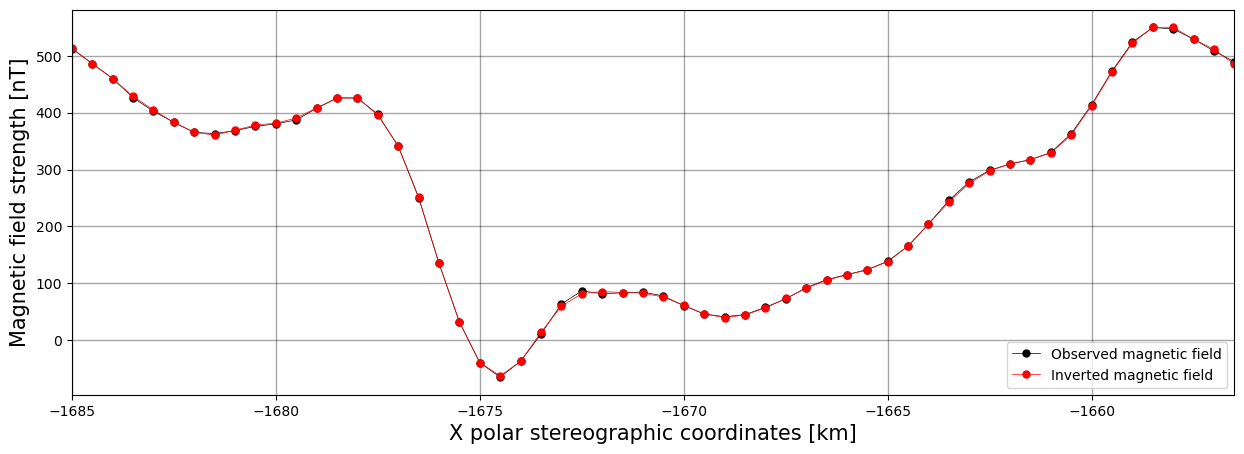

In [19]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(
    obs_mag_horizontal_profile[:, 0] / 1000,
    obs_mag_horizontal_profile[:, 2],
    "o-k",
    linewidth=0.5,
    markersize=5,
    label="Observed magnetic field",
)
plt.plot(
    syn_mag_horizontal_profile[:, 0] / 1000,
    syn_mag_horizontal_profile[:, 2],
    "o-r",
    linewidth=0.5,
    markersize=5,
    label="Inverted magnetic field",
)
ax2.set_xlim([-1685000 / 1000, -1656500 / 1000])
ax2.legend(loc="lower right", prop={"size": 10})
ax2.set_ylabel("Magnetic field strength [nT]", fontsize=15)
ax2.set_xlabel("X polar stereographic coordinates [km]", fontsize=15)
ax2.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
plt.savefig(
    export_profiles + "magnetic_data_points_along_horizontal_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

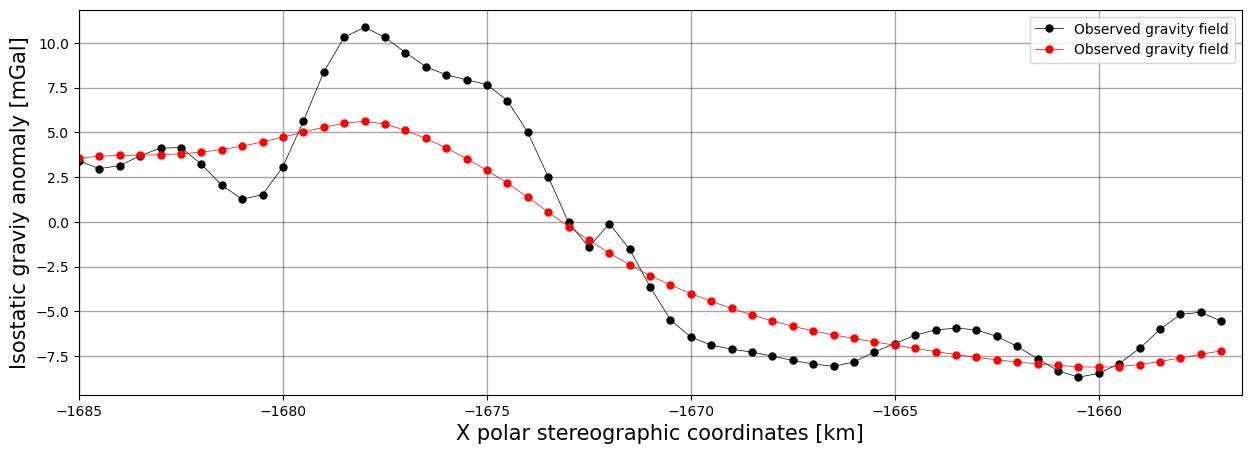

In [20]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(
    obs_grav_horizontal_profile[:, 0] / 1000,
    obs_grav_horizontal_profile[:, 2],
    "o-k",
    linewidth=0.5,
    markersize=5,
    label="Observed gravity field",
)
plt.plot(
    syn_grav_horizontal_profile[:, 0] / 1000,
    syn_grav_horizontal_profile[:, 2],
    "o-r",
    linewidth=0.5,
    markersize=5,
    label="Observed gravity field",
)
ax2.set_xlim([-1685000 / 1000, -1656500 / 1000])
ax2.legend(loc="upper right", prop={"size": 10})
ax2.set_ylabel("Isostatic graviy anomaly [mGal]", fontsize=15)
ax2.set_xlabel("X polar stereographic coordinates [km]", fontsize=15)
ax2.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
plt.savefig(
    export_profiles + "gravity_data_points_along_horizontal_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

# Plot vertical profiles

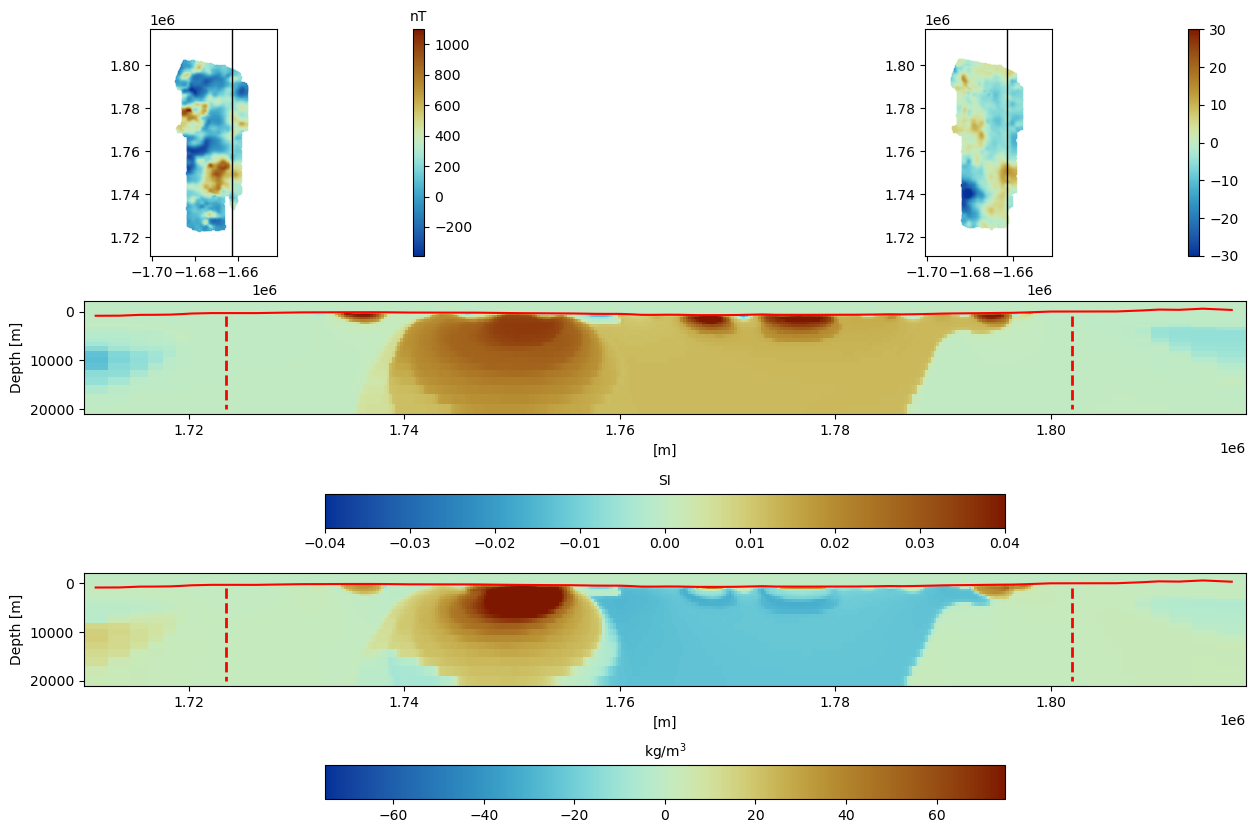

In [21]:
y_profil, z_profil = np.meshgrid(Y_sus, Depth_sus)

j = 117


# define fontsize
fontsize_index = 10

sus_profil_ix = inv_sus[:, :, j]
line_x = (xq[0, j], xq[0, j])
line_y = (min(y_profil[0, :]), max(y_profil[0, :]))

dens_profil_ix = inv_dens[:, :, j]


## plot profile location
figure1 = plt.figure(figsize=(15, 10), facecolor="white")
spec = figure1.add_gridspec(3, 2, hspace=0.2, wspace=1)
ax0 = figure1.add_subplot(spec[0, 0])

im1 = plt.scatter(
    X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=2, cmap=cmap_rev, vmax=1100
)
axes = plt.gca()
cb1 = plt.colorbar(im1, shrink=1, orientation="vertical", pad=0.35)
cb1.ax.set_title("nT", fontsize=fontsize_index)
ax0.plot(line_x, line_y, color="k", linewidth=1)
plt.gca().set_aspect(1)
ax0.set_xlim(np.min(X_sus), np.max(X_sus))
ax0.set_ylim(np.min(Y_sus), np.max(Y_sus))

# plot sus profil
ax2 = figure1.add_subplot(spec[1, :])
im2 = plt.pcolormesh(
    y_profil, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("[m]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.35)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(y_profil[0, :], topointer[:, j] * -1, c="red", label="Bedrock")
ax2.vlines(
    x=[np.min(y_study_area), np.max(y_study_area)],
    ymin=[1000, 1000],
    ymax=[20000, 20000],
    colors="red",
    ls="--",
    lw=2,
)


ax3 = figure1.add_subplot(spec[0, 1])

im3 = plt.scatter(
    X_input_grav,
    Y_input_grav,
    c=val_input_grav,
    marker="s",
    s=2,
    cmap=cmap_rev,
    vmin=-30,
    vmax=30,
)
# Coastline.plot(ax=ax3 , color = 'k' , linewidth = 0.5)
axes = plt.gca()
cb3 = plt.colorbar(im3, shrink=1, orientation="vertical", pad=0.35)
# cb1.ax.set_title("mGal", fontsize=fontsize_index)
ax3.plot(line_x, line_y, color="k", linewidth=1)
plt.gca().set_aspect(1)
ax3.set_xlim(np.min(X_sus), np.max(X_sus))
ax3.set_ylim(np.min(Y_sus), np.max(Y_sus))

# plot sus profil
ax4 = figure1.add_subplot(spec[2, :])
im4 = plt.pcolormesh(
    y_profil,
    z_profil,
    dens_profil_ix,
    cmap=cmap_rev,
    vmin=-75,
    vmax=75,
)
plt.xlabel("[m]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im4, shrink=1, orientation="horizontal", pad=0.35)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(y_profil[0, :], topointer[:, j] * -1, c="red", label="Bedrock")
ax4.vlines(
    x=[np.min(y_study_area), np.max(y_study_area)],
    ymin=[1000, 1000],
    ymax=[20000, 20000],
    colors="red",
    ls="--",
    lw=2,
)
plt.savefig(
    export_profiles + "VI_vertical_profile_overview.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

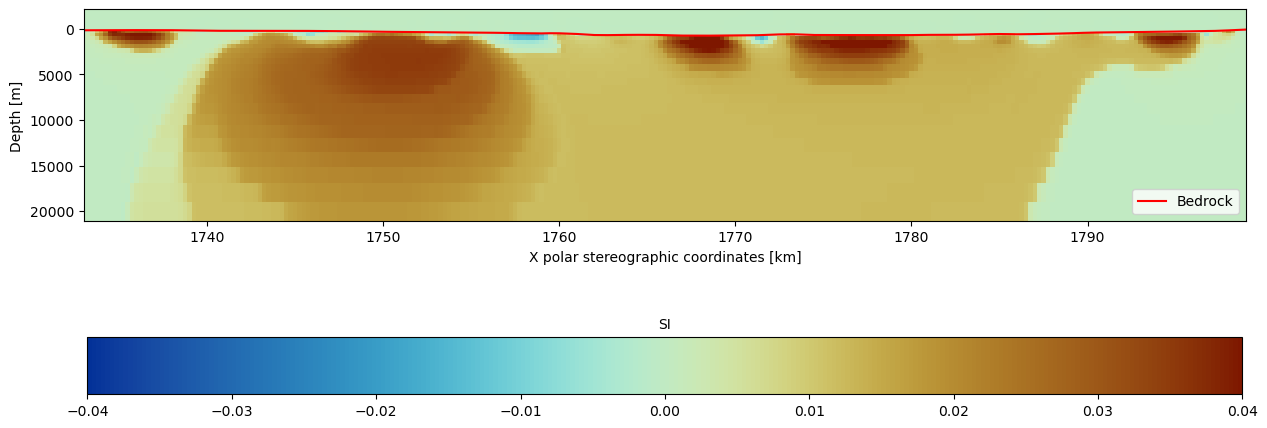

In [22]:
## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = ax2.pcolormesh(
    y_profil / 1000, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
ax2.set_xlim([1733000 / 1000, 1799000 / 1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(y_profil[0, :] / 1000, topointer[:, j] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
plt.savefig(
    export_profiles + "sus_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

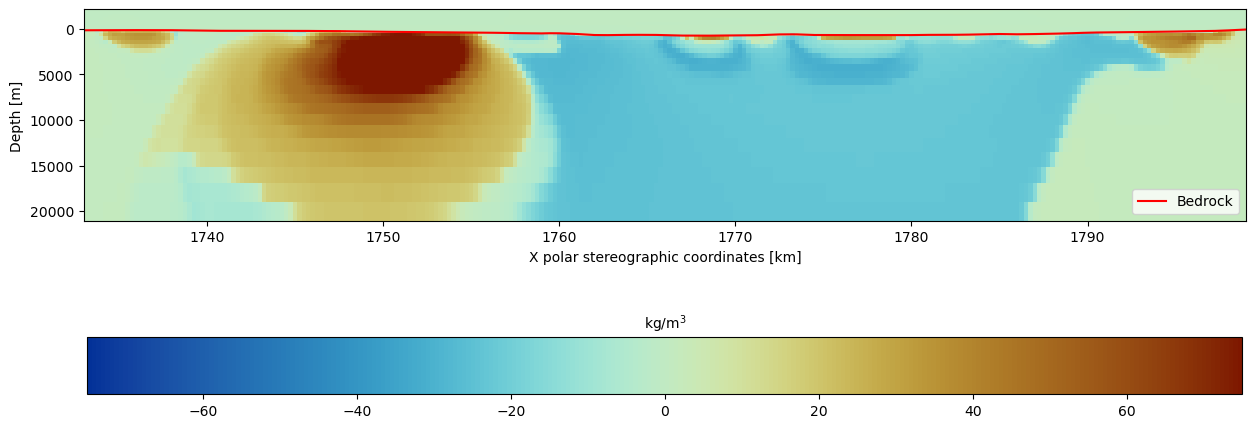

In [23]:
## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = ax2.pcolormesh(
    y_profil / 1000, z_profil, dens_profil_ix, cmap=cmap_rev, vmin=-75, vmax=75
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([1733000 / 1000, 1799000 / 1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(y_profil[0, :] / 1000, topointer[:, j] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
plt.savefig(
    export_profiles + "density_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

# Plot obsereved and inverted data points along profiles

In [24]:
# find data points for horizontal profile
obs_mag_vertical_profile_ix = []
for i in range(len(Mag_obs_merged[:, 0])):
    if Mag_obs_merged[i, 0] == -1663000:
        obs_mag_vertical_profile_ix.append(Mag_obs_merged[i, :])
obs_mag_vertical_profile = np.array(obs_mag_vertical_profile_ix)

syn_mag_vertical_profile_ix = []
for i in range(len(Mag_syn_merged[:, 1])):
    if Mag_syn_merged[i, 0] == -1663000:
        syn_mag_vertical_profile_ix.append(Mag_syn_merged[i, :])
syn_mag_vertical_profile = np.array(syn_mag_vertical_profile_ix)

obs_grav_vertical_profile_ix = []
for i in range(len(Grav_obs_merged[:, 1])):
    if Grav_obs_merged[i, 0] == -1663000:
        obs_grav_vertical_profile_ix.append(Grav_obs_merged[i, :])
obs_grav_vertical_profile = np.array(obs_grav_vertical_profile_ix)

syn_grav_vertical_profile_ix = []
for i in range(len(Grav_syn_merged[:, 1])):
    if Grav_syn_merged[i, 0] == -1663000:
        syn_grav_vertical_profile_ix.append(Grav_syn_merged[i, :])
syn_grav_vertical_profile = np.array(syn_grav_vertical_profile_ix)

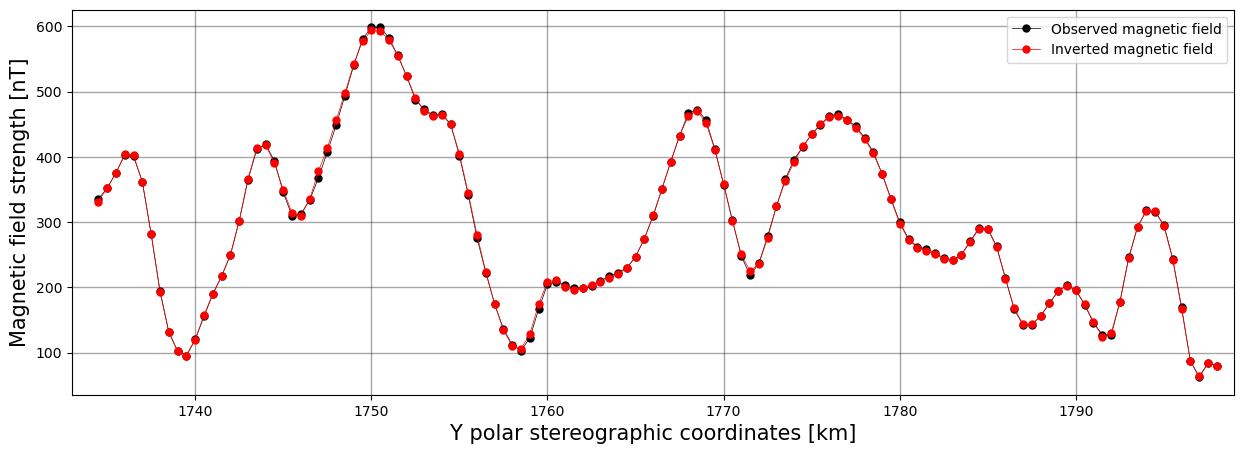

In [25]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(
    obs_mag_vertical_profile[:, 1] / 1000,
    obs_mag_vertical_profile[:, 2],
    "o-k",
    linewidth=0.5,
    markersize=5,
    label="Observed magnetic field",
)
plt.plot(
    syn_mag_vertical_profile[:, 1] / 1000,
    syn_mag_vertical_profile[:, 2],
    "o-r",
    linewidth=0.5,
    markersize=5,
    label="Inverted magnetic field",
)
ax2.set_xlim([1733000 / 1000, 1799000 / 1000])
ax2.legend(loc="upper right", prop={"size": 10})
ax2.set_ylabel("Magnetic field strength [nT]", fontsize=15)
ax2.set_xlabel("Y polar stereographic coordinates [km]", fontsize=15)
ax2.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
plt.savefig(
    export_profiles + "magnetic_data_points_along_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

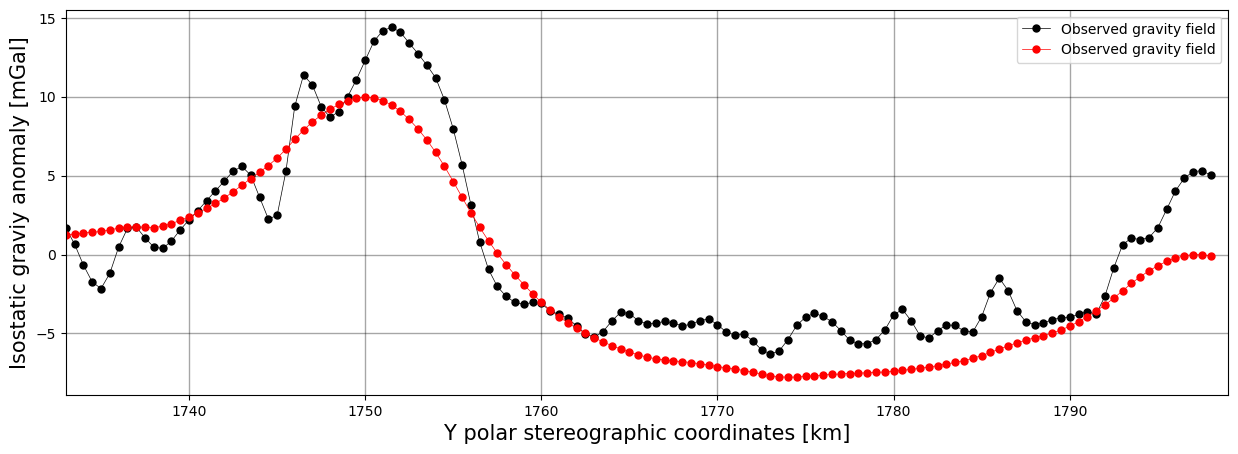

In [26]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(
    obs_grav_vertical_profile[:, 1] / 1000,
    obs_grav_vertical_profile[:, 2],
    "o-k",
    linewidth=0.5,
    markersize=5,
    label="Observed gravity field",
)
plt.plot(
    syn_grav_vertical_profile[:, 1] / 1000,
    syn_grav_vertical_profile[:, 2],
    "o-r",
    linewidth=0.5,
    markersize=5,
    label="Observed gravity field",
)
ax2.set_xlim([1733000 / 1000, 1799000 / 1000])
# ax2.set_ylim([25, 100])
ax2.legend(loc="upper right", prop={"size": 10})
ax2.set_ylabel("Isostatic graviy anomaly [mGal]", fontsize=15)
ax2.set_xlabel("Y polar stereographic coordinates [km]", fontsize=15)
ax2.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
plt.savefig(
    export_profiles + "gravity_data_points_along_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

# Plot horizontal depth sliceses

In [27]:
export_sus_dens_slide = inv_run + "Output/Figure/depth_sliceses/"
if not os.path.exists(export_sus_dens_slide):
    os.makedirs(export_sus_dens_slide)

for c in tqdm(range(len(Depth_inversion_km))):
    figure1 = plt.figure(figsize=(10, 8), facecolor="white")

    inv_dens_depth_slice = inv_dens[c, :, :]
    inv_sus_depth_slice = inv_sus[c, :, :]

    ax1 = plt.subplot(1, 2, 1)
    plt.title("Density at {:.1f} km depth".format(Depth_inversion_km[c]))
    im1 = plt.pcolormesh(xq, yq, inv_dens_depth_slice, cmap=cmap_rev, vmin=-75, vmax=75)
    axes = plt.gca()
    cb = plt.colorbar(im1, shrink=0.3)
    cb.ax.set_title(unit_dens, fontsize=10)
    ax1.plot(x_study_area, y_study_area, "r", linewidth=2, label="study area")
    ax1.legend(loc="lower right", prop={"size": 10})

    ax2 = plt.subplot(1, 2, 2)
    plt.title("Susceptibility at {:.1f} km depth".format(Depth_inversion_km[c]))
    im2 = plt.pcolormesh(
        xq, yq, inv_sus_depth_slice, cmap=cmap_rev, vmin=-0.06, vmax=0.06
    )
    axes = plt.gca()
    cb = plt.colorbar(im2, shrink=0.3)
    cb.ax.set_title(unit_sus, fontsize=10)
    ax2.plot(x_study_area, y_study_area, "r", linewidth=2, label="study area")
    ax2.legend(loc="lower right", prop={"size": 10})

    export_name = export_sus_dens_slide + "horizontal_slice_{}.png".format(c + 100)
    plt.savefig(
        export_name, dpi=300, facecolor=figure1.get_facecolor(), transparent=True
    )

    plt.close()

  0%|          | 0/33 [00:00<?, ?it/s]

# Density susceptiblity relationship plots

In [28]:
VI_cov = nc4.Dataset(inv_run + "VI_inversion/Susceptibility_cov.nc")
XX_mag_mesh = VI_cov.variables["Northing"][:]
YY_mag_mesh = VI_cov.variables["Easting"][:]
VI_cov_mesh = VI_cov.variables["Susceptibility"][:]

VI_cov.close()

In [29]:
x_stack_ix = []
y_stack_ix = []
z_stack_ix = []

for i in range(len(Depth_inversion_km)):

    x_stack_ix.append(xq)
    y_stack_ix.append(yq)

    z_stack_zeros = np.zeros((len(xq[:, 0]), len(xq[0, :])))
    z_stack_zeros[:, :] = Depth_inversion_km[i] * 1000
    z_stack_ix.append(z_stack_zeros)

x_stack = np.array(x_stack_ix)
y_stack = np.array(y_stack_ix)
z_stack = np.array(z_stack_ix)

In [30]:
crossplot_data = np.vstack(
    (
        inv_sus.flatten(),
        inv_dens.flatten(),
        x_stack.flatten(),
        y_stack.flatten(),
        z_stack.flatten(),
        VI_cov_mesh.flatten(),
    )
).T
np.savetxt("inversion_cube.txt", crossplot_data, delimiter=",", header="susceptibility,gravity,x,y,z,VI_cov")

In [31]:
crossplot_data_cleaned_ix = []

for i in range(len(crossplot_data[:, 0])):
    if crossplot_data[i, 5] == 1:
        crossplot_data_cleaned_ix.append(crossplot_data[i, :])
crossplot_data_cleaned = np.array(crossplot_data_cleaned_ix)

In [32]:
crossplot_data_cleaned_study_area_ix = []
for i in range(len(crossplot_data_cleaned[:, 0])):
    if (
        crossplot_data_cleaned[i, 2] > np.min(x_study_area)
        and crossplot_data_cleaned[i, 2] < np.max(x_study_area)
        and crossplot_data_cleaned[i, 3] > np.min(y_study_area)
        and crossplot_data_cleaned[i, 3] < np.max(y_study_area)
    ):
        crossplot_data_cleaned_study_area_ix.append(crossplot_data_cleaned[i, :])
crossplot_data_cleaned_study_area = np.array(crossplot_data_cleaned_study_area_ix)

In [33]:
crossplot_data_cleaned = []  # clear "crossplot_data_cleaned" variable
crossplot_data_cleaned = (
    crossplot_data_cleaned_study_area  # refill "crossplot_data_cleaned" variable
)

In [34]:
# crop model extension
crossplot_data_cleaned_limted_ix = []
for g in range(len(crossplot_data_cleaned[:, 4])):
    if (
        crossplot_data_cleaned[g, 4] < 20000
    ):  # crop here the depth extension of the model e.g. only the first 10km (Here we take the full model extension).
        crossplot_data_cleaned_limted_ix.append(crossplot_data_cleaned[g, :])
crossplot_data_cleaned_limted = np.array(crossplot_data_cleaned_limted_ix)

In [35]:
cluster_data = np.vstack(
    (
        crossplot_data_cleaned_limted[:, 0],
        crossplot_data_cleaned_limted[:, 1],
        crossplot_data_cleaned_limted[:, 2],
        crossplot_data_cleaned_limted[:, 3],
        crossplot_data_cleaned_limted[:, 4],
    )
).T
clustered_data = cluster_data

Text(0.5, 1.0, 'Counts')

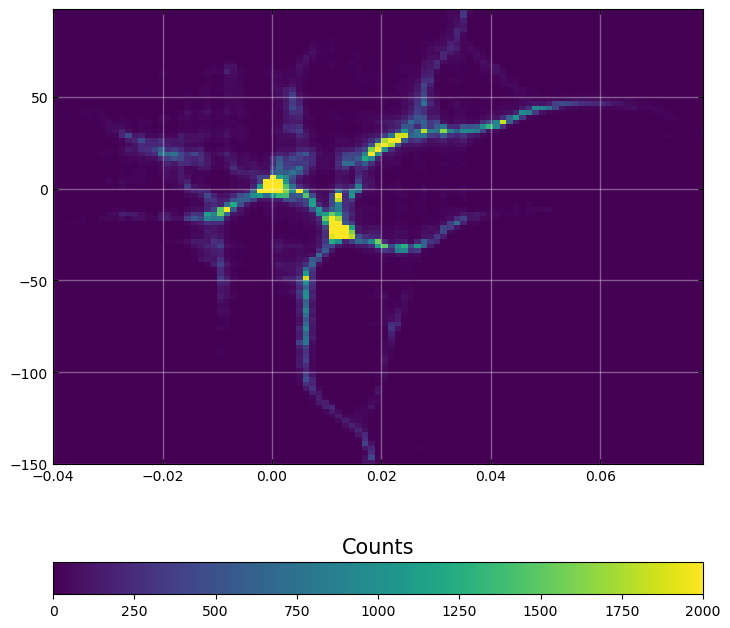

In [36]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)

h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")

cb = figure1.colorbar(h[3], ax=ax_scatter, orientation="horizontal")
cb.ax.set_title("Counts", fontsize=15)

In [37]:
## create cluster polygons

# cluster 1
x_ps_point_list_cluster1 = [0.01, 0.01, 0.0147, 0.0147, 0.01]
y_ps_point_list_cluster1 = [-13, -29, -29, -19, -13]
polygon_geom_cluster1 = Polygon(zip(x_ps_point_list_cluster1, y_ps_point_list_cluster1))

# cluster 2
x_ps_point_list_cluster2 = [-0.0025, -0.0025, 0.0025, 0.0025, -0.0025]
y_ps_point_list_cluster2 = [7, -3, -3, 7, 7]
polygon_geom_cluster2 = Polygon(zip(x_ps_point_list_cluster2, y_ps_point_list_cluster2))

# cluster 3
x_ps_point_list_cluster3 = [0.0145, 0.019, 0.026, 0.023, 0.0145]
y_ps_point_list_cluster3 = [18, 15, 28, 32, 18]
polygon_geom_cluster3 = Polygon(zip(x_ps_point_list_cluster3, y_ps_point_list_cluster3))

# cluster 4
x_ps_point_list_cluster4 = [0.026, 0.035, 0.035, 0.023, 0.026]
y_ps_point_list_cluster4 = [28, 30, 35, 32, 28]
polygon_geom_cluster4 = Polygon(zip(x_ps_point_list_cluster4, y_ps_point_list_cluster4))

# cluster 5
x_ps_point_list_cluster5 = [0.035, 0.052, 0.05, 0.035, 0.035]
y_ps_point_list_cluster5 = [28, 43, 46, 35, 28]
polygon_geom_cluster5 = Polygon(zip(x_ps_point_list_cluster5, y_ps_point_list_cluster5))

# cluster 6
x_ps_point_list_cluster6 = [-0.013, -0.01, -0.005, -0.007, -0.013]
y_ps_point_list_cluster6 = [-16, -16, -8, -4, -16]
polygon_geom_cluster6 = Polygon(zip(x_ps_point_list_cluster6, y_ps_point_list_cluster6))

# cluster 7
x_ps_point_list_cluster7 = [0.005, 0.005, 0.007, 0.007, 0.005]
y_ps_point_list_cluster7 = [-43, -110, -110, -43, -43]
polygon_geom_cluster7 = Polygon(zip(x_ps_point_list_cluster7, y_ps_point_list_cluster7))


# cluster 8
x_ps_point_list_cluster8 = [0.023, 0.029, 0.029, 0.036, 0.033, 0.026, 0.026, 0.023]
y_ps_point_list_cluster8 = [32, 35, 55, 90, 90, 55, 38, 32]
polygon_geom_cluster8 = Polygon(zip(x_ps_point_list_cluster8, y_ps_point_list_cluster8))

# cluster 9
x_ps_point_list_cluster9 = [0.022, 0.028, 0.035, 0.05, 0.033, 0.028, 0.022, 0.022]
y_ps_point_list_cluster9 = [-35, -35, -20, -14, -12, -26, -26, -35]
polygon_geom_cluster9 = Polygon(zip(x_ps_point_list_cluster9, y_ps_point_list_cluster9))

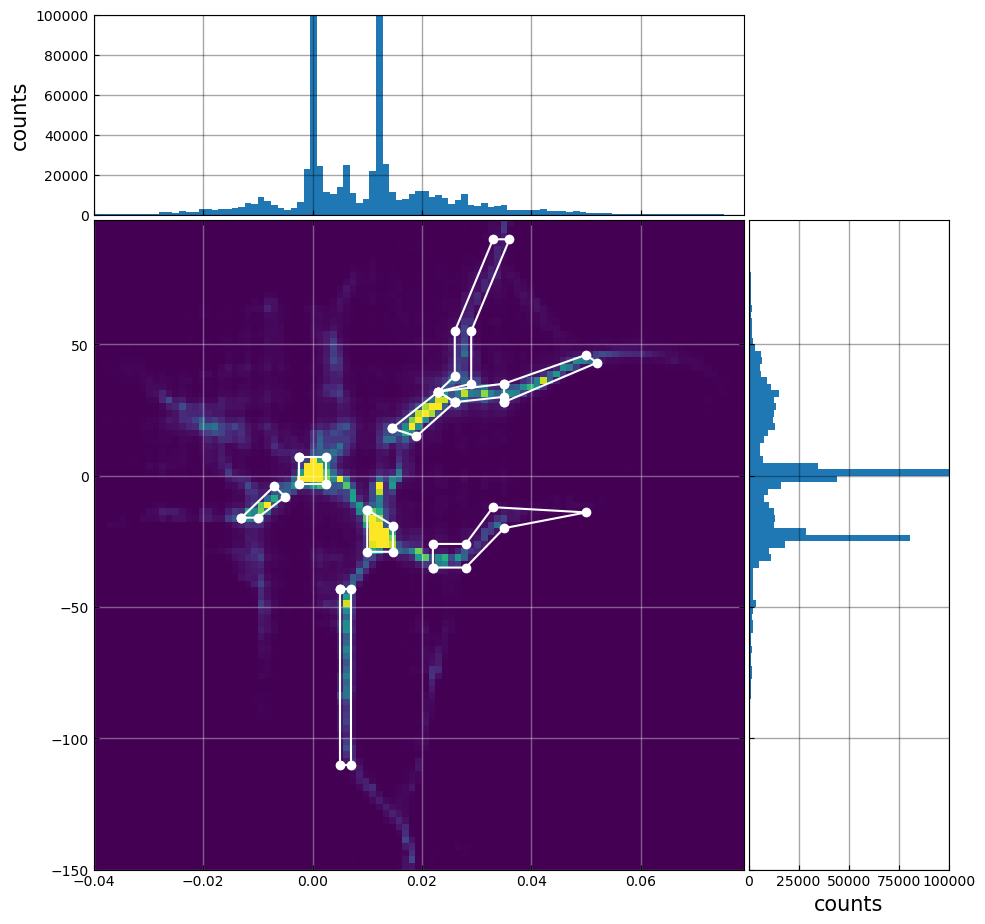

In [38]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")


ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction="in", labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction="in", labelleft=False)


h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")

ax_scatter.plot(x_ps_point_list_cluster1, y_ps_point_list_cluster1, "o-w")
ax_scatter.plot(x_ps_point_list_cluster2, y_ps_point_list_cluster2, "o-w")
ax_scatter.plot(x_ps_point_list_cluster3, y_ps_point_list_cluster3, "o-w")
ax_scatter.plot(x_ps_point_list_cluster4, y_ps_point_list_cluster4, "o-w")
ax_scatter.plot(x_ps_point_list_cluster5, y_ps_point_list_cluster5, "o-w")
ax_scatter.plot(x_ps_point_list_cluster6, y_ps_point_list_cluster6, "o-w")
ax_scatter.plot(x_ps_point_list_cluster7, y_ps_point_list_cluster7, "o-w")
ax_scatter.plot(x_ps_point_list_cluster8, y_ps_point_list_cluster8, "o-w")
ax_scatter.plot(x_ps_point_list_cluster9, y_ps_point_list_cluster9, "o-w")

# x histogramm
ax_histx.hist(
    crossplot_data_cleaned_limted[:, 0], bins=np.arange(-0.04, 0.08, 0.0012)
)  # histogramm plot
ax_histx.set_xlim(ax_scatter.get_xlim())  # set limites to scatter limites
ax_histx.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax_histx.set_ylabel("counts", fontsize=15)
ax_histx.set_ylim(0, 100000)

ax_histy.hist(
    crossplot_data_cleaned_limted[:, 1],
    bins=np.arange(-150, 100, 2.5),
    orientation="horizontal",
)  # histogramm plot
ax_histy.set_ylim(ax_scatter.get_ylim())  # set limites to scatter limites
ax_histy.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax_histy.set_xlabel("counts", fontsize=15)
ax_histy.set_xlim(0, 100000)
plt.savefig(
    export_fig_path + "gravity_data_points_along_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

# Cluster locationsplots (Supplementary Information)

In [39]:
supplementary_info = inv_run + "Output/Figure/locations_plots_supplementary_info/"

# Create path if it does not exists
if not os.path.exists(supplementary_info):
    os.makedirs(supplementary_info)

In [40]:
m = 15  # fontsize
cmap = cm.roma_r
cmap_rev = cm.roma_r
cmap_grav_diff = plt.get_cmap("RdBu", 20)

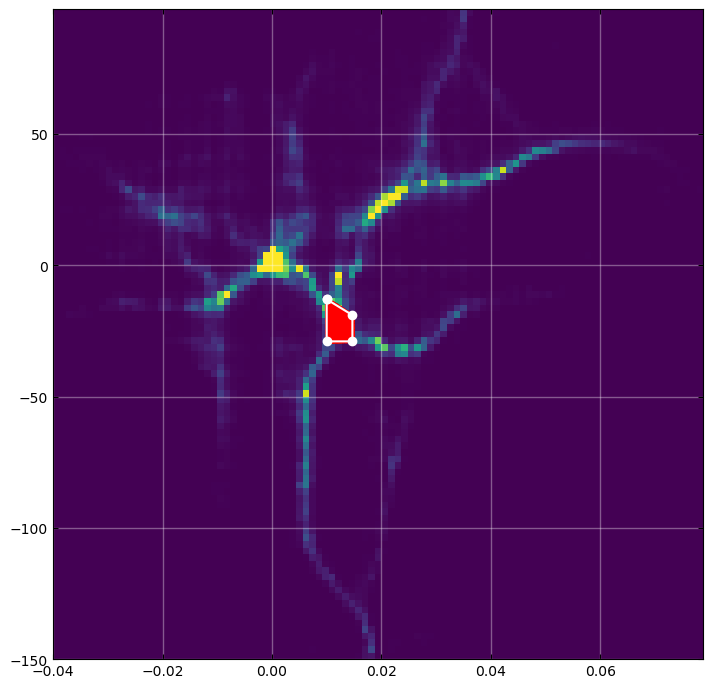

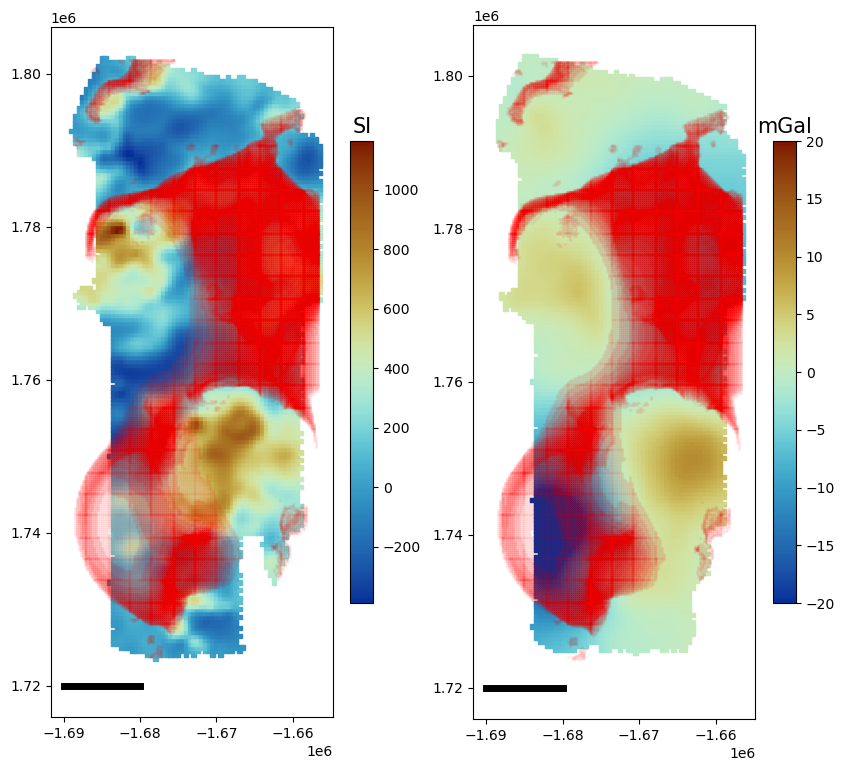

In [41]:
inverted_data_polygon_cluster1_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster1) == True:
        inverted_data_polygon_cluster1_ix.append(clustered_data[i, :])
inverted_data_cluster1 = np.array(inverted_data_polygon_cluster1_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster1, y_ps_point_list_cluster1, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster1[:, 0], inverted_data_cluster1[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster1[:, 2],
    inverted_data_cluster1[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster1[:, 2],
    inverted_data_cluster1[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

plt.savefig(
    supplementary_info + "flatten_locations_cluster1.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

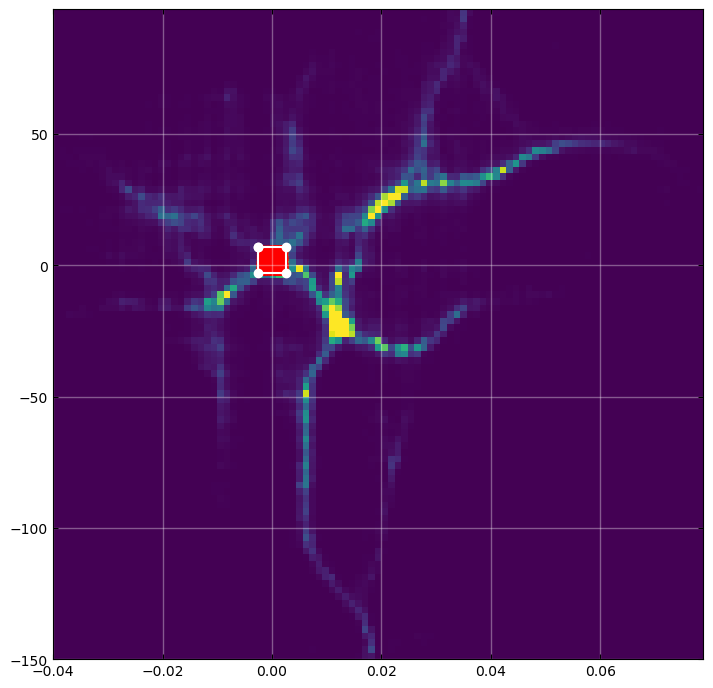

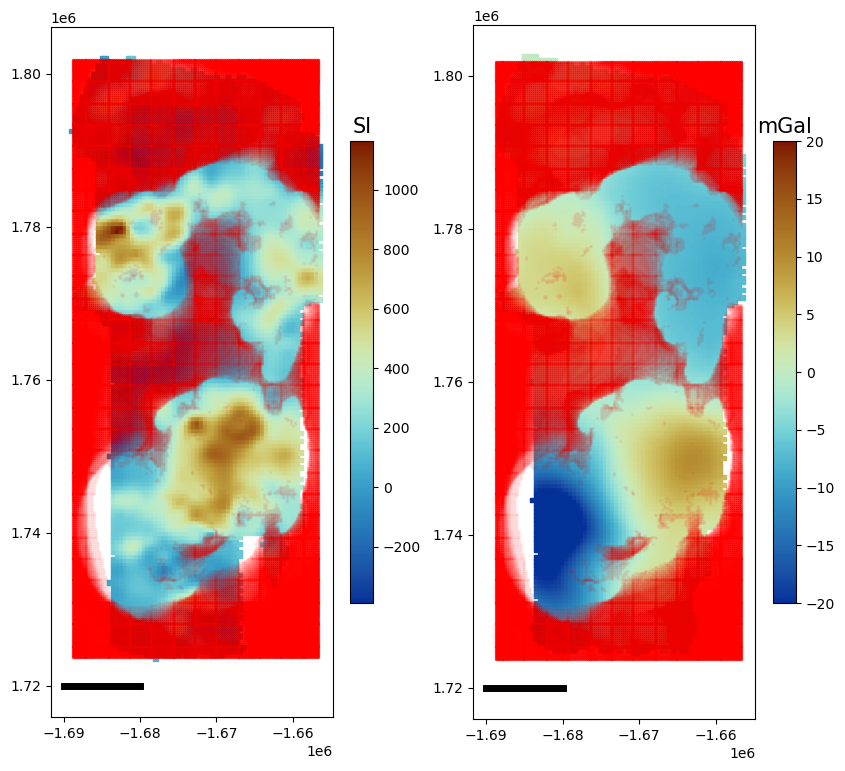

In [42]:
inverted_data_polygon_cluster2_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster2) == True:
        inverted_data_polygon_cluster2_ix.append(clustered_data[i, :])
inverted_data_cluster2 = np.array(inverted_data_polygon_cluster2_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster2, y_ps_point_list_cluster2, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster2[:, 0], inverted_data_cluster2[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster2[:, 2],
    inverted_data_cluster2[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster2[:, 2],
    inverted_data_cluster2[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


plt.savefig(
    supplementary_info + "flatten_locations_cluster2.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

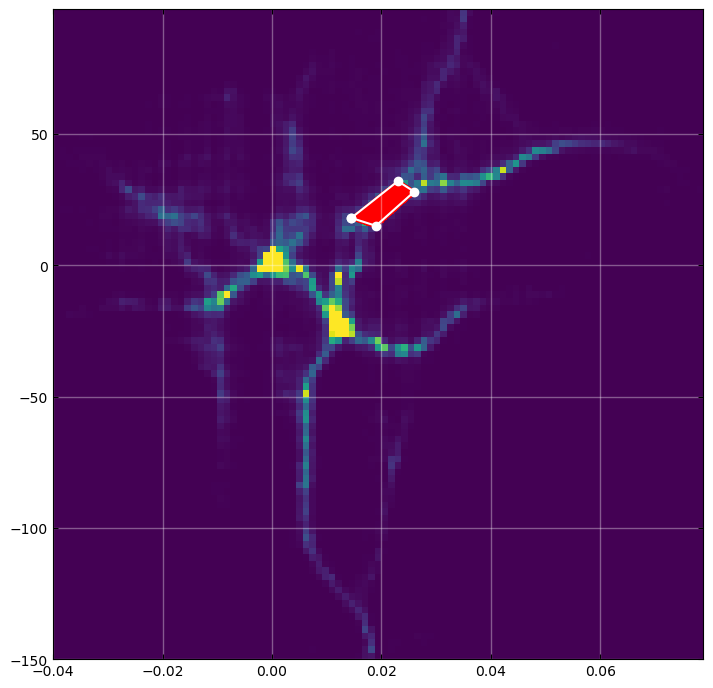

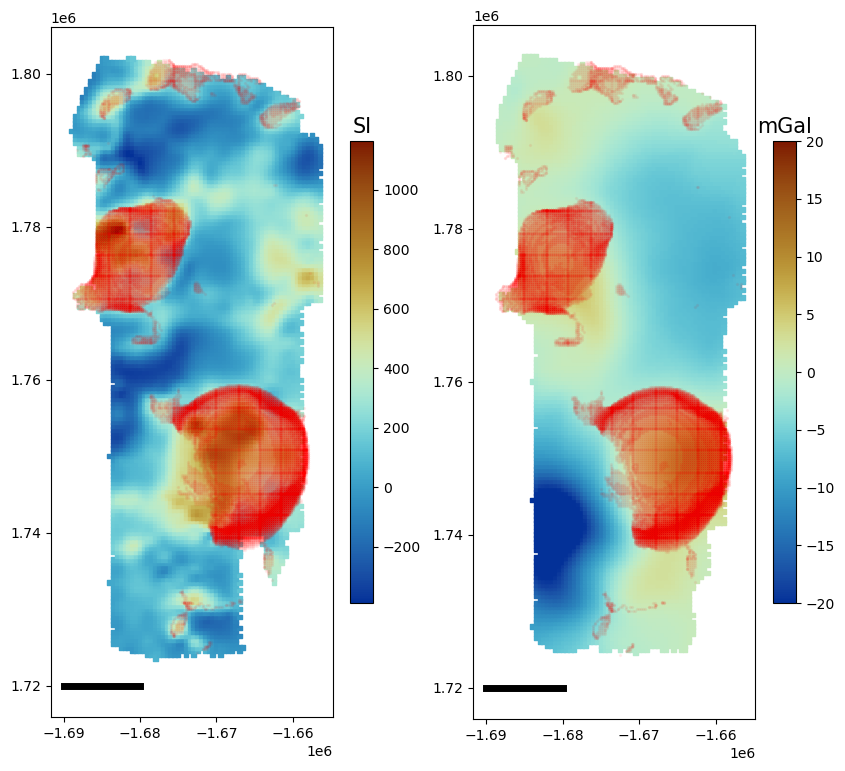

In [43]:
inverted_data_polygon_cluster3_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster3) == True:
        inverted_data_polygon_cluster3_ix.append(clustered_data[i, :])
inverted_data_cluster3 = np.array(inverted_data_polygon_cluster3_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster3, y_ps_point_list_cluster3, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster3[:, 0], inverted_data_cluster3[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster3[:, 2],
    inverted_data_cluster3[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster3[:, 2],
    inverted_data_cluster3[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


plt.savefig(
    supplementary_info + "flatten_locations_cluster3.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

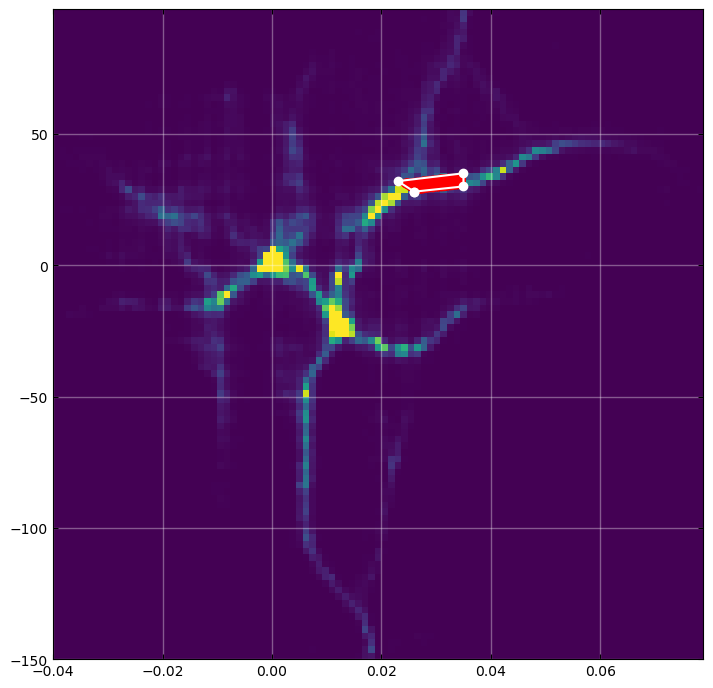

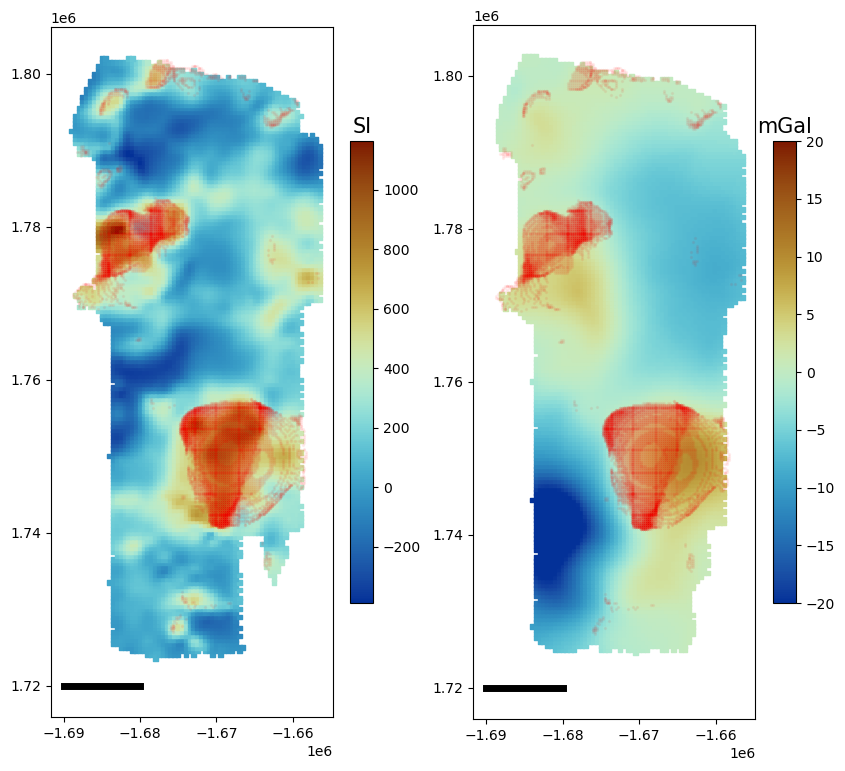

In [44]:
inverted_data_polygon_cluster4_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster4) == True:
        inverted_data_polygon_cluster4_ix.append(clustered_data[i, :])
inverted_data_cluster4 = np.array(inverted_data_polygon_cluster4_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster4, y_ps_point_list_cluster4, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster4[:, 0], inverted_data_cluster4[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster4[:, 2],
    inverted_data_cluster4[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster4[:, 2],
    inverted_data_cluster4[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

plt.savefig(
    supplementary_info + "flatten_locations_cluster4.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

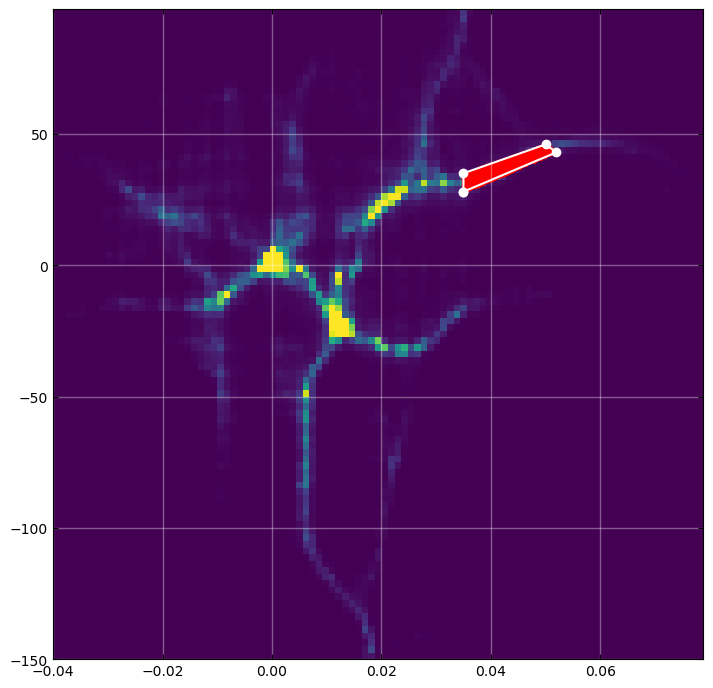

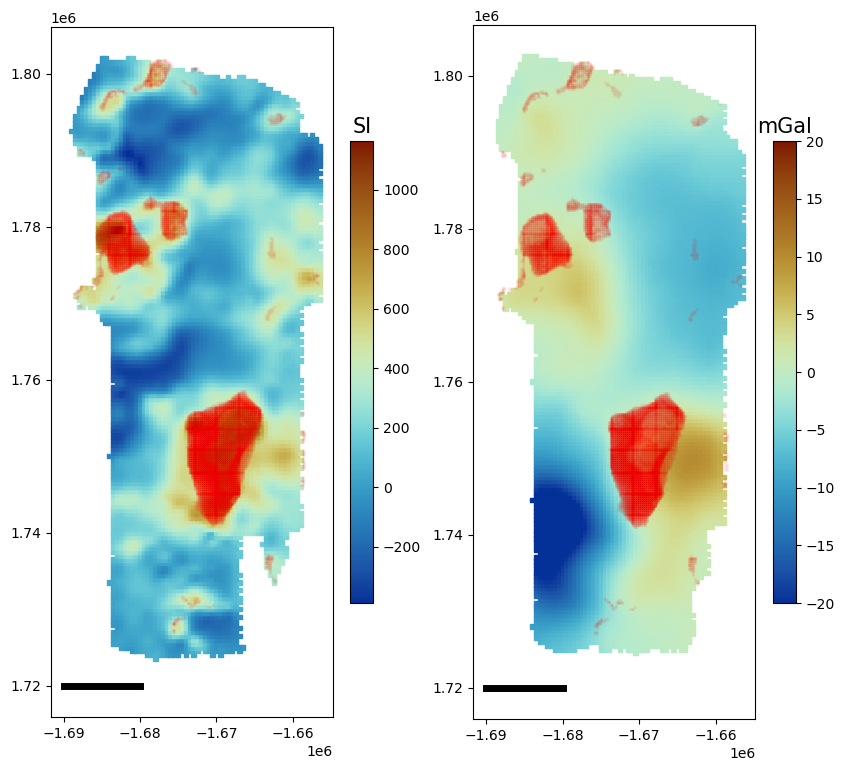

In [45]:
inverted_data_polygon_cluster5_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster5) == True:
        inverted_data_polygon_cluster5_ix.append(clustered_data[i, :])
inverted_data_cluster5 = np.array(inverted_data_polygon_cluster5_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster5, y_ps_point_list_cluster5, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster5[:, 0], inverted_data_cluster5[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster5[:, 2],
    inverted_data_cluster5[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster5[:, 2],
    inverted_data_cluster5[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


plt.savefig(
    supplementary_info + "flatten_locations_cluster5.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

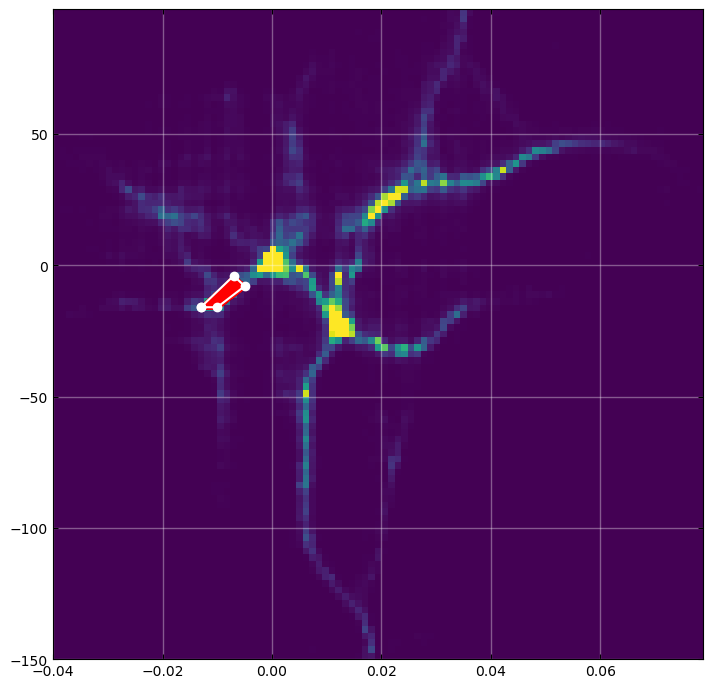

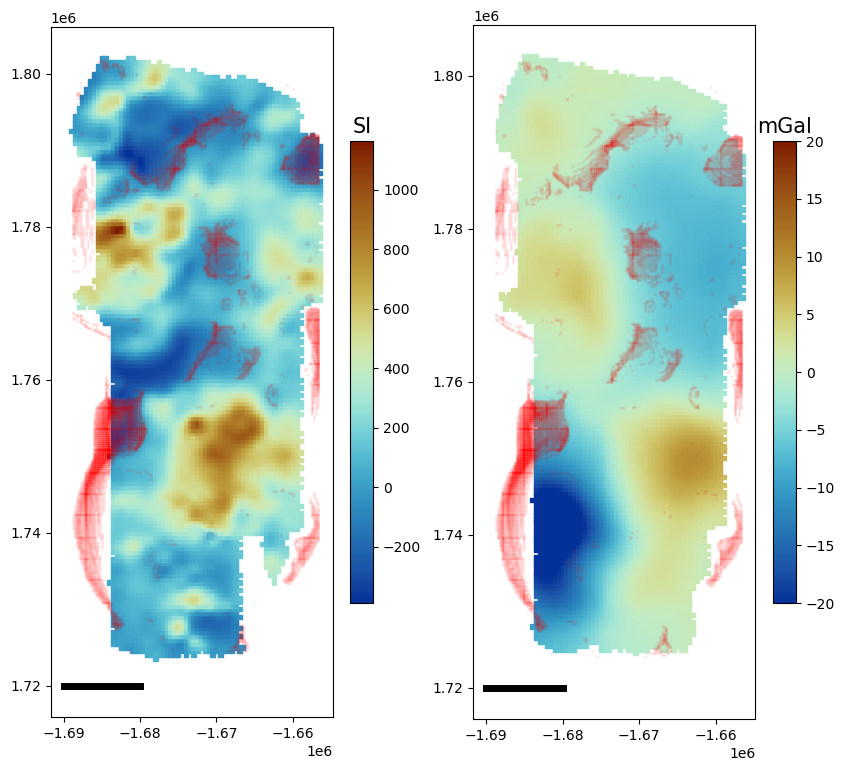

In [46]:
inverted_data_polygon_cluster6_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster6) == True:
        inverted_data_polygon_cluster6_ix.append(clustered_data[i, :])
inverted_data_cluster6 = np.array(inverted_data_polygon_cluster6_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster6, y_ps_point_list_cluster6, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster6[:, 0], inverted_data_cluster6[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster6[:, 2],
    inverted_data_cluster6[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster6[:, 2],
    inverted_data_cluster6[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

plt.savefig(
    supplementary_info + "flatten_locations_cluster6.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

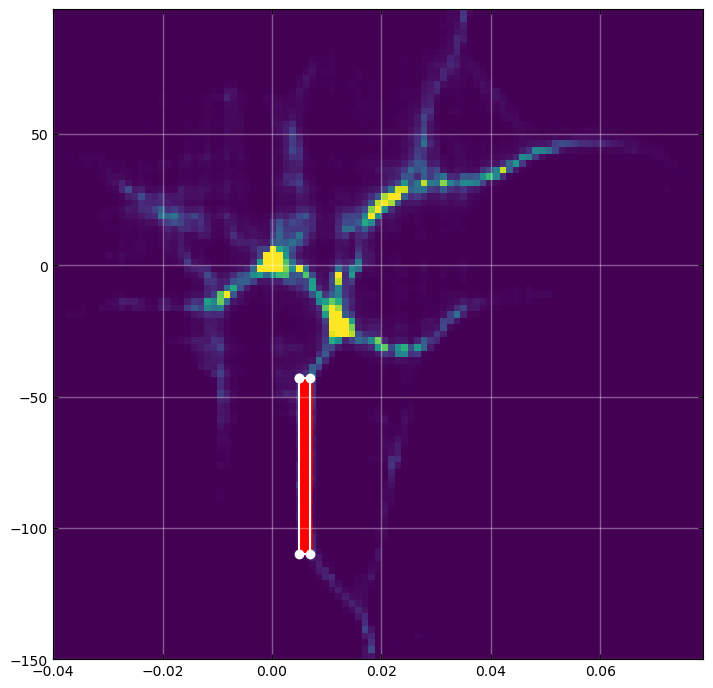

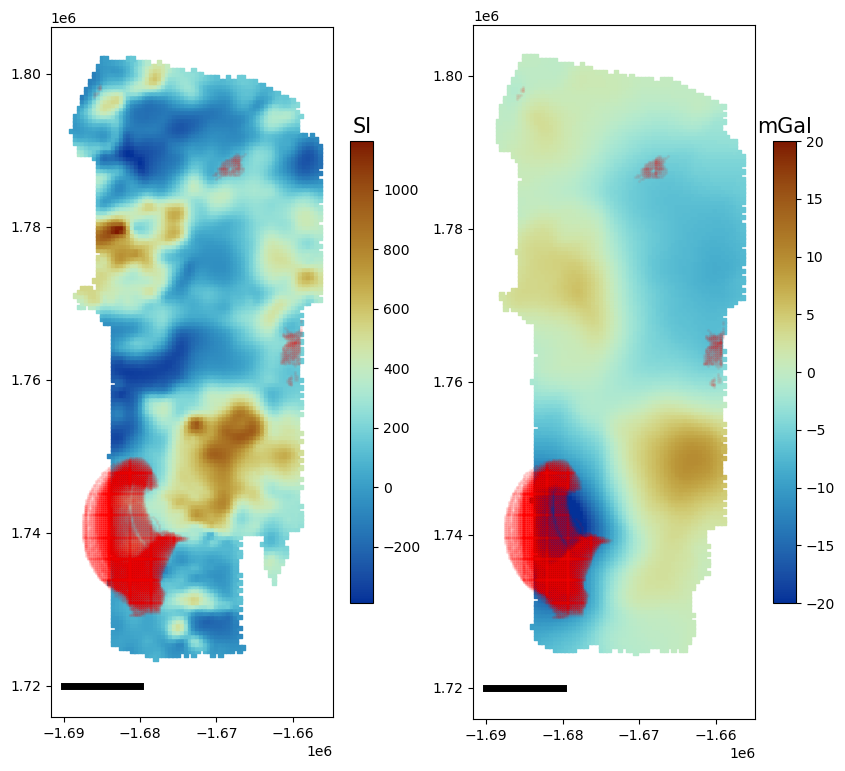

In [47]:
inverted_data_polygon_cluster7_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster7) == True:
        inverted_data_polygon_cluster7_ix.append(clustered_data[i, :])
inverted_data_cluster7 = np.array(inverted_data_polygon_cluster7_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster7, y_ps_point_list_cluster7, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster7[:, 0], inverted_data_cluster7[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster7[:, 2],
    inverted_data_cluster7[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster7[:, 2],
    inverted_data_cluster7[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

plt.savefig(
    supplementary_info + "flatten_locations_cluster7.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

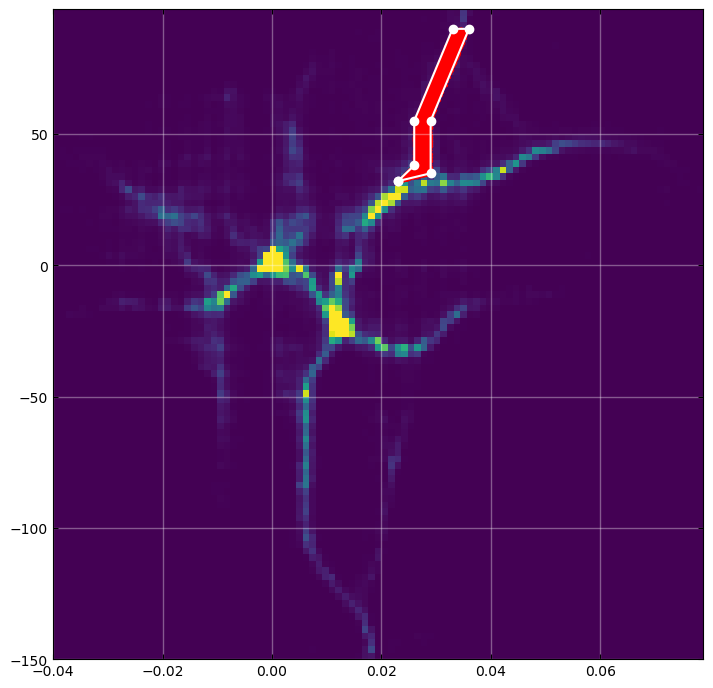

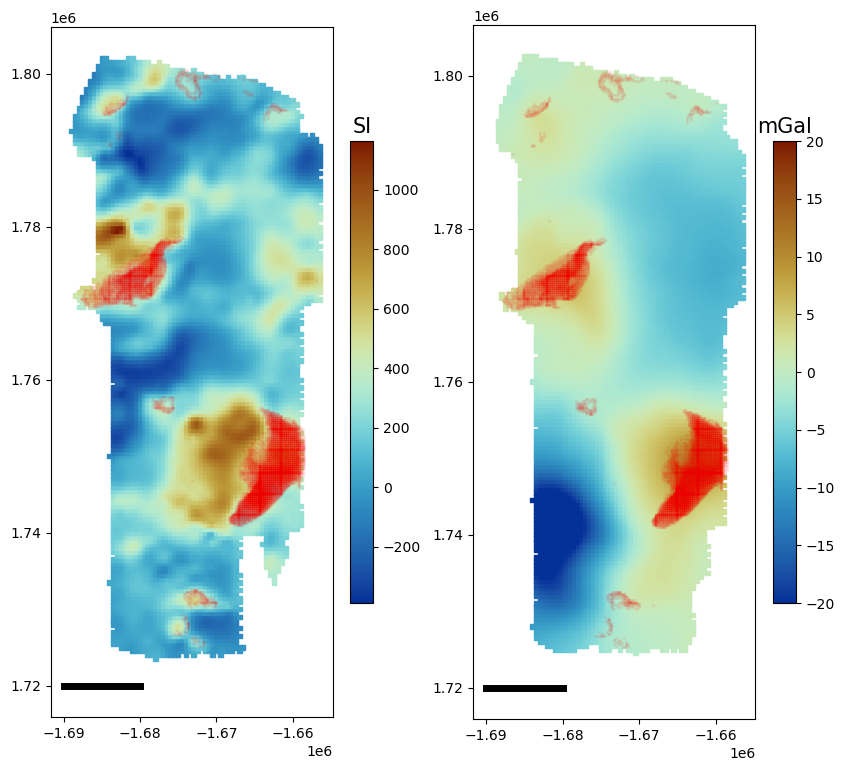

In [48]:
inverted_data_polygon_cluster8_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster8) == True:
        inverted_data_polygon_cluster8_ix.append(clustered_data[i, :])
inverted_data_cluster8 = np.array(inverted_data_polygon_cluster8_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster8, y_ps_point_list_cluster8, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster8[:, 0], inverted_data_cluster8[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster8[:, 2],
    inverted_data_cluster8[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster8[:, 2],
    inverted_data_cluster8[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar


plt.savefig(
    supplementary_info + "flatten_locations_cluster8.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

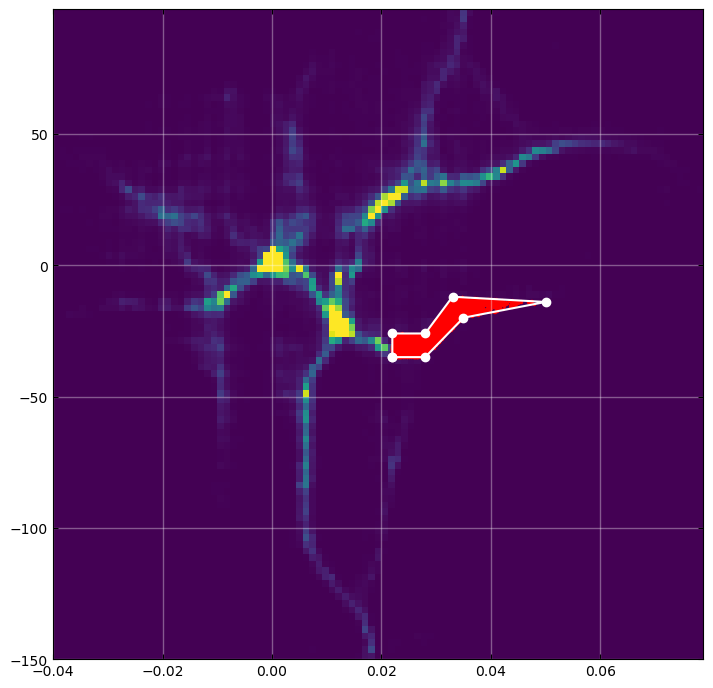

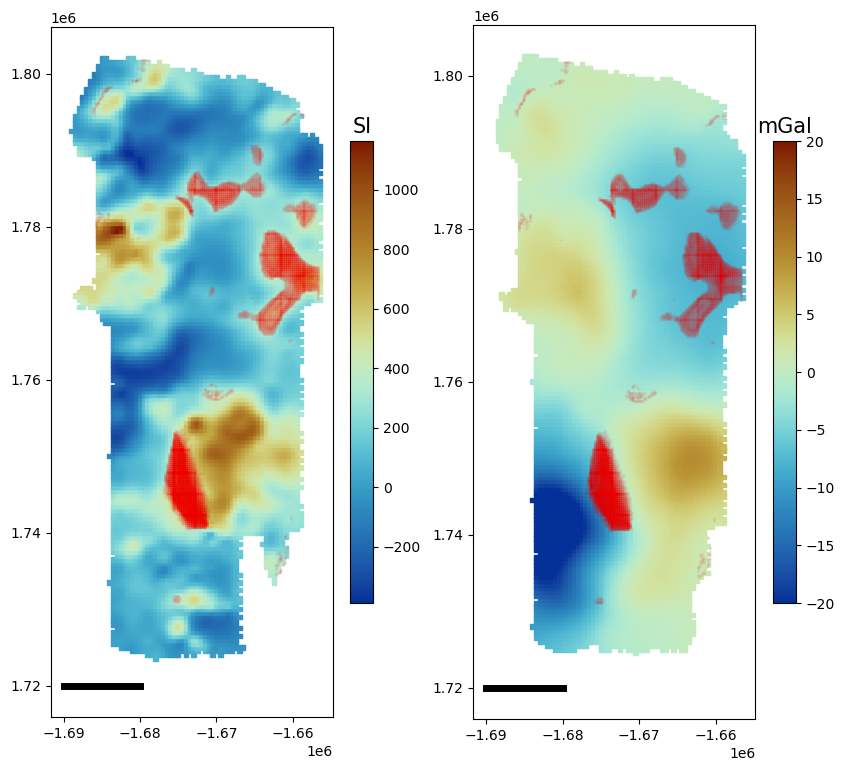

In [49]:
inverted_data_polygon_cluster9_ix = []

for i in range(len(clustered_data[:, 0])):
    points_ix = Point(clustered_data[i, 0], clustered_data[i, 1])
    if points_ix.within(polygon_geom_cluster9) == True:
        inverted_data_polygon_cluster9_ix.append(clustered_data[i, :])
inverted_data_cluster9 = np.array(inverted_data_polygon_cluster9_ix)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]

# start with a rectangular Figure
figure1 = plt.figure(figsize=(10, 10), facecolor="white")

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
h = ax_scatter.hist2d(
    clustered_data[:, 0],
    clustered_data[:, 1],
    bins=(np.arange(-0.04, 0.08, 0.0012), np.arange(-150, 100, 2.5)),
    vmax=2000,
)
ax_scatter.plot(x_ps_point_list_cluster9, y_ps_point_list_cluster9, "o-w")
ax_scatter.grid(color="w", linestyle="-", linewidth=1, alpha=0.35, which="major")
ax = ax_scatter.scatter(
    inverted_data_cluster9[:, 0], inverted_data_cluster9[:, 1], marker="o", s=2, c="r"
)

figure2 = plt.figure(figsize=(10, 10), facecolor="white")

ax1 = plt.subplot(1, 2, 1)
im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=10, cmap=cmap)
plt.scatter(
    inverted_data_cluster9[:, 2],
    inverted_data_cluster9[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=0.6)
cb1.ax.set_title("SI", fontsize=15)
ax1.set_aspect(1)
ax1.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

ax2 = plt.subplot(1, 2, 2)
im2 = plt.scatter(
    X_syn_grav,
    Y_syn_grav,
    c=val_syn_grav,
    marker="s",
    s=10,
    cmap=cmap_rev,
    vmin=-20,
    vmax=20,
)
plt.scatter(
    inverted_data_cluster9[:, 2],
    inverted_data_cluster9[:, 3],
    marker="o",
    s=2,
    c="r",
    alpha=0.05,
)
axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=0.6)
cb2.ax.set_title("mGal", fontsize=15)
ax2.set_aspect(1)
ax2.plot(
    [-1690000, -1690000 + 10000], [1720000, 1720000], "-k", linewidth=5
)  # 10 km scale bar

plt.savefig(
    supplementary_info + "flatten_locations_cluster9.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)